# Imports

In [1]:
from full_system_hamiltonian import *
from get_setup import params_for_n_site_Hamiltonian
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import expm
from numba import njit, objmode
from scipy.sparse.linalg import eigsh
import time


# Initialize params and operators

In [2]:
n_sites = 3
dupes = 3
big_N = n_sites * dupes

pars, extras = params_for_n_site_Hamiltonian(n_sites, configs=None, specified_vals={"U": [0.1]}, path="/home/Hishem/repos/MastersThesis/configuration.json")


t, U, eps, Delta = pars

print("t, U, eps, Delta =", t, U, eps, Delta)

t_couple = t 
delta_couple = Delta


t: [1. 1.]
U: [0.1 0.1]
eps: [-0.10097739030086553, -0.6071436946690216, -0.0032830574591187892]
Delta: [1.001265238594651, 1.0015039227972797]
t, U, eps, Delta = [1. 1.] [0.1 0.1] [-0.10097739030086553, -0.6071436946690216, -0.0032830574591187892] [1.001265238594651, 1.0015039227972797]


In [3]:
n, dup = n_sites, dupes
def precompute_operators(big_N):
    operators = {}
    cre, ann, num = precompute_ops(big_N)
    operators['cre'] = cre
    operators['ann'] = ann
    operators['num'] = num
    hop_ops = {}
    pair_ops = {}
    dens_ops = {}
    for d in range(dup):
        off = d * n
        for i in range(n-1):
            a, b = off+i, off+i+1
            hop_ops[(a,b)] = cre[a] @ ann[b] + cre[b] @ ann[a] 
            pair_ops[(a,b)] = cre[a] @ cre[b] + ann[b] @ ann[a]
            dens_ops[(a,b)] = num[a] @ num[b]
    # Inter PMM coupling terms
    # Inner dots only for now
    hop_ops[(0,n)] = cre[0] @ ann[n] + ann[0] @ cre[n] #A0 - B0
    hop_ops[(0,2*n)] = cre[0] @ ann[2*n] + ann[0] @ cre[2*n] #A0 - C0
    # hop_ops[(n,2*n)] = cre[n] @ ann[2*n] + ann[n] @ cre[2*n] #B0 - C0
    operators['hop'] = hop_ops
    operators['pair'] = pair_ops
    operators['dens'] = dens_ops
    return operators
operators = precompute_operators(big_N)



# Create hamiltonian and delta pulse function

In [4]:
def simple_delta_pulse(t, T_peak, width, s, max_val,min_val):
    T_start = T_peak - width / 2
    T_end = T_peak + width / 2

    rise = 1/(1 + np.exp(-s*(t - T_start)))
    fall = 1/(1 + np.exp(s*(t - T_end)))

    return min_val + (max_val - min_val) * rise * fall


In [5]:

def hamiltonian(n, dup, t_vals, U_vals, eps_vals, delta_vals,
               couplings=(), eps_detune=None, operators=None):

    big_N = dup * n
    dim = 2**big_N
    H = np.zeros((dim, dim), dtype=complex)
    if operators is None:
        cre, ann, num = precompute_ops(big_N)
        hop_ops = {}
        pair_ops = {}
        dens_ops = {}
        for d in range(dup):
            off = d * n
            for i in range(n-1):
                a, b = off+i, off+i+1
                hop_ops[(a,b)] = cre[a] @ ann[b] + cre[b] @ ann[a] 
                pair_ops[(a,b)] = cre[a] @ cre[b] + ann[b] @ ann[a]
                dens_ops[(a,b)] = num[a] @ num[b]
        # Inter PMM coupling terms
        # Inner dots only for now
        hop_ops[(0,n)] = cre[0] @ ann[n] + ann[0] @ cre[n] #A0 - B0
        hop_ops[(0,2*n)] = cre[0] @ ann[2*n] + ann[0] @ cre[2*n] #A0 - C0
        # hop_ops[(n,2*n)] = cre[n] @ ann[2*n] + ann[n] @ cre[2*n] #B0 - C0
    else:
        cre = operators["cre"]
        ann = operators["ann"]
        num = operators["num"]
        hop_ops = operators["hop"]
        pair_ops = operators["pair"]
        dens_ops = operators["dens"]
    # cre, ann, num = precompute_ops(big_N)

    eps_full = np.tile(eps_vals, (dup,1))
    if eps_detune is not None:
        for i in range(len(eps_detune)):
            site, node, val = eps_detune[i]
            eps_full[int(site), int(node)] = val


    # Intra PMM terms
    for d in range(dup):
        off = d * n
        for j in range(n-1):
            i, k = off+j, off+j+1
            # print(f"Adding intra-PMM terms between sites {i} and {k}")
            H += -t_vals[j]   * hop_ops[(i,k)]
            H +=  delta_vals[j] * pair_ops[(i,k)]
            H +=  U_vals[j]   * dens_ops[(i,k)]

        for j in range(n):
            H += eps_full[d,j] * num[off+j]


    #  Inter or additional PMM couplings
    for cA, cB, t_c, d_c in couplings:
        if cA is None or cB is None:
            continue

        i = cA[0]*n + cA[1]
        j = cB[0]*n + cB[1]
        key = (min(i,j), max(i,j))
        if t_c != 0:
            H += -t_c * hop_ops[key]
        if d_c != 0 and cA[0]*n == cB[0]*n:
            H +=  d_c * pair_ops[key]
        if cA[0] != cB[0] and d_c != 0:
            raise RuntimeError("Inter-PMM pairing forbidden")
    return H

def calculate_parities(eigenvecs, eigenvals, P):
    parities = np.sum(eigenvecs.conj().T @ P @ eigenvecs, axis=0).real
    even_idxs = np.where(parities > 0)[0]
    odd_idxs = np.where(parities < 0)[0]

    even_energies = eigenvals[even_idxs]
    odd_energies = eigenvals[odd_idxs]

    even_vecs = eigenvecs[:, even_idxs]
    odd_vecs = eigenvecs[:, odd_idxs]

    return even_energies, odd_energies, even_vecs, odd_vecs

def collect_parity_arrays(eigvals, eigvecs, time_array):


    dim = eigvecs.shape[1]
    dimhalf = eigvecs.shape[1] // 2

    even_vals = np.zeros((len(time_array), dimhalf), dtype=complex)
    odd_vals = np.zeros((len(time_array), dimhalf), dtype=complex)
    even_vecs = np.zeros((len(time_array), dim, dimhalf), dtype=complex)
    odd_vecs = np.zeros((len(time_array), dim, dimhalf), dtype=complex)



    for idx in tqdm(range(len(time_array))):
        even_energies, odd_energies, even_vecs_t, odd_vecs_t = calculate_parities(eigvecs[idx], eigvals[idx], total_parity(operators['num']))
        even_vals[idx,:len(even_energies)] = even_energies
        odd_vals[idx,:len(odd_energies)] = odd_energies
        even_vecs[idx,:,:len(even_energies)] = even_vecs_t
        odd_vecs[idx,:,:len(odd_energies)] = odd_vecs_t


    return even_vals, odd_vals, even_vecs, odd_vecs

# Test hamiltonian connections

In [6]:
AB_coupling = [(0,2), (1,0), 0.0]
BC_coupling = [(1,0), (2,0), 0.0]
CA_coupling = [(2,0), (0,2), 0.0]

couplings = [
    AB_coupling,
    BC_coupling,
    CA_coupling
]

# eps_detune = None#{1: 0.0}
# eps_detune = [[0,0,0.0]] #site , node , val
H = hamiltonian(n_sites, dupes, t, U, eps, Delta, operators=operators)


eigvals, eigvecs = np.linalg.eigh(H)
print(eigvals[:10])

[-6.97300714 -6.97291322 -6.97291322 -6.97291322 -6.9728193  -6.9728193
 -6.9728193  -6.97272537 -5.20772486 -5.20772486]


In [7]:
def majorana_operators(n):
    create, annihilate, number = precompute_ops(n)
    majorana_ops = []
    for j in range(n):
        f_dag = create[j]
        f = annihilate[j]
        gamma_1 = f + f_dag
        gamma_2 = -1j * (f - f_dag)
        majorana_ops.append((gamma_1, gamma_2))
    return majorana_ops



def calculate_parities(eigenvecs, eigenvals, number_ops):
    P = total_parity(number_ops)

    #find even and odd parity indexes
    parities = []
    for i in range(eigenvecs.shape[1]):
        vec = eigenvecs[:,i]
        parity = vec.conj().T @ P @ vec
        parities.append(parity.real)
    parities = np.array(parities)
    even_idxs = np.where(parities > 0)[0]
    odd_idxs = np.where(parities < 0)[0]

    even_energies = eigenvals[even_idxs]
    odd_energies = eigenvals[odd_idxs]

    even_vecs = eigenvecs[:, even_idxs]
    odd_vecs = eigenvecs[:, odd_idxs]

    return even_energies, odd_energies, even_vecs, odd_vecs, even_idxs, odd_idxs, parities


cutoff = 8
t, U, eps, Delta = pars
H = hamiltonian(n_sites, dupes, t, U, eps, Delta, operators=operators)
eigvals, eigvecs = np.linalg.eigh(H)
even_energies, odd_energies, even_vecs, odd_vecs, even_idxs, odd_idxs, parities = calculate_parities(eigvecs, eigvals, operators['num'])

even_vecs = even_vecs[:, :cutoff]
odd_vecs = odd_vecs[:, :cutoff]
even_energies = even_energies[:cutoff]
odd_energies = odd_energies[:cutoff]

# print(len(eigvals))
print(len(even_energies), len(odd_energies))
def majorana_population(even_vecs, odd_vecs, majorana_ops):
    M = np.zeros((even_vecs.shape[1], big_N), dtype=np.complex128)

    for j in range(big_N):
        Gamma_1, Gamma_2 = majorana_ops[j]
        for i in range(even_vecs.shape[1]):
            v_e = even_vecs[:, i]
            v_o = odd_vecs[:, i]
            term1 = np.vdot(v_o, Gamma_1 @ v_e)
            term2 = np.vdot(v_o, Gamma_2 @ v_e)
            M[i, j] = term1**2 + term2**2
    return M


majorana_ops = majorana_operators(big_N)



8 8


# Evolve the system

In [8]:
def evolve_system(Total_time, time_steps, params, tJ, dJ, eps_detune_val):
    """ 
    Information about setup:
    A, B, C = 1, 2, 3
    inner, middle, outer = 0, 1, 2
    Relevant γ's:
    γ_0 = (site 0, node 0)
    γ_1 = (site 0, node 2)
    γ_2 = (site 1, node 0)
    γ_3 = (site 2, node 0)

    Order of connections:
    T = 0:
        γ_0 -- γ_1
            junction_couplings = None
            eps_detune = None
    T = 1/3 Total_time:
        γ_0 -- γ_2
            junction_couplings = [AB_coupling]
            eps_detune = [[A, outer, eps_detune_val]]
    T = 2/3 Total_time:
        γ_0 -- γ_3
            junction_couplings = [AC_coupling]
            eps_detune = [[A, outer, eps_detune_val]]
    T = Total_time:
        γ_0 -- γ_1
            junction_couplings = None
            eps_detune = None
    """
    #Base parameters
    t_val, U_val, eps_val, Delta_val = params
    width = Total_time / 3
    s = 20/width#

    dT, dD = 5, 5  # Add perturbations to intra PMM couplings

    #System setup
    A, B, C = 0, 1, 2
    outer, middle, inner = 2, 1, 0

    time_array = np.linspace(0, Total_time, time_steps)
    eps_detune_min = eps_val[0]
    eps_detune = []
    couplings = []
    for i in range(len(time_array)):
        t = time_array[i]

        #Tune chemical potentials for detuning
        detune_A = simple_delta_pulse(t, Total_time/2, 2*width, s, eps_detune_val, 0.0)
        
        tj_pulse_AB = simple_delta_pulse(t, Total_time/3, width, s, tJ, 0.0)
        tj_pulse_AC = simple_delta_pulse(t, 2*Total_time/3, width, s, tJ, 0.0)

        eps_detune.append([[A, outer, detune_A]])

        tj_pulse_A = (tj_pulse_AB + tj_pulse_AC) / np.linalg.norm(2*tJ) * (tJ + dT)  #+ t_val[0]
        dj_pulse_A = (tj_pulse_AB + tj_pulse_AC) / np.linalg.norm(2*tJ) * (dJ + dD)  #+ Delta_val[0]

        coups = [[(A, inner), (B, inner), tj_pulse_AB, 0.0],
                 [(C, inner), (A, inner), tj_pulse_AC, 0.0],
                 [(A, inner), (A, middle), tj_pulse_A, dj_pulse_A],
                 [(A, middle), (A, outer), tj_pulse_A, dj_pulse_A]
                 ]
        couplings.append(coups)

    dim = 2**big_N#//2
    eigvals = np.zeros((time_steps, dim), dtype=complex)
    eigvecs = np.zeros((time_steps, dim, dim), dtype=complex)
    gap = np.zeros(time_steps, dtype=complex)

    parity_op = total_parity(operators['num'])
    P_eigvals, P_eigvecs = np.linalg.eigh(parity_op)
    even_idxs = np.where(P_eigvals > 0)[0]
    odd_idxs = np.where(P_eigvals < 0)[0]

    for i in tqdm(range(len(time_array))):

        H_t = hamiltonian(n_sites, dupes, t_val, U_val, eps_val, Delta_val,
                          couplings=couplings[i],
                          eps_detune=eps_detune[i],
                          operators=operators)

        # H_proj = P_eigvecs[:, even_idxs].conj().T @ H_t @ P_eigvecs[:, even_idxs]

        # eigvals_t, eigvecs_t = np.linalg.eigh(H_proj)
        eigvals_t, eigvecs_t = np.linalg.eigh(H_t)
        eigvals[i] = eigvals_t
        eigvecs[i] = eigvecs_t
        gap[i] = eigvals_t[2] - eigvals_t[1]


    return time_array, couplings, eps_detune, eigvals, eigvecs, gap


Total_time = 300.0
n_time_steps = 1000
tJ = t_couple[0]
dJ = delta_couple[0]
eps_detune_val = tJ*1.5

time_array, couplings, eps_detune, eigvals, eigvecs, gap = evolve_system(Total_time, n_time_steps, pars, tJ, dJ, eps_detune_val)


100%|██████████| 1000/1000 [01:16<00:00, 13.10it/s]


In [9]:
#get the parities
even_vals, odd_vals, even_vecs, odd_vecs = collect_parity_arrays(eigvals, eigvecs, range(len(time_array)))


  0%|          | 3/1000 [00:00<01:36, 10.33it/s]

Time idx 0: Even energies = 256, Odd energies = 256
Time idx 1: Even energies = 256, Odd energies = 256
Time idx 2: Even energies = 256, Odd energies = 256


  0%|          | 5/1000 [00:00<01:34, 10.51it/s]

Time idx 3: Even energies = 256, Odd energies = 256
Time idx 4: Even energies = 256, Odd energies = 256
Time idx 5: Even energies = 256, Odd energies = 256


  1%|          | 9/1000 [00:00<01:32, 10.75it/s]

Time idx 6: Even energies = 256, Odd energies = 256
Time idx 7: Even energies = 256, Odd energies = 256
Time idx 8: Even energies = 256, Odd energies = 256


  1%|          | 11/1000 [00:01<01:31, 10.82it/s]

Time idx 9: Even energies = 256, Odd energies = 256
Time idx 10: Even energies = 256, Odd energies = 256
Time idx 11: Even energies = 256, Odd energies = 256


  2%|▏         | 15/1000 [00:01<01:31, 10.73it/s]

Time idx 12: Even energies = 256, Odd energies = 256
Time idx 13: Even energies = 256, Odd energies = 256
Time idx 14: Even energies = 256, Odd energies = 256


  2%|▏         | 17/1000 [00:01<01:32, 10.66it/s]

Time idx 15: Even energies = 256, Odd energies = 256
Time idx 16: Even energies = 256, Odd energies = 256
Time idx 17: Even energies = 256, Odd energies = 256


  2%|▏         | 21/1000 [00:01<01:33, 10.52it/s]

Time idx 18: Even energies = 256, Odd energies = 256
Time idx 19: Even energies = 256, Odd energies = 256
Time idx 20: Even energies = 256, Odd energies = 256


  2%|▏         | 23/1000 [00:02<01:33, 10.40it/s]

Time idx 21: Even energies = 256, Odd energies = 256
Time idx 22: Even energies = 256, Odd energies = 256
Time idx 23: Even energies = 256, Odd energies = 256


  3%|▎         | 27/1000 [00:02<01:32, 10.51it/s]

Time idx 24: Even energies = 256, Odd energies = 256
Time idx 25: Even energies = 256, Odd energies = 256
Time idx 26: Even energies = 256, Odd energies = 256


  3%|▎         | 29/1000 [00:02<01:32, 10.54it/s]

Time idx 27: Even energies = 256, Odd energies = 256
Time idx 28: Even energies = 256, Odd energies = 256
Time idx 29: Even energies = 256, Odd energies = 256


  3%|▎         | 33/1000 [00:03<01:31, 10.52it/s]

Time idx 30: Even energies = 256, Odd energies = 256
Time idx 31: Even energies = 256, Odd energies = 256
Time idx 32: Even energies = 256, Odd energies = 256


  4%|▎         | 35/1000 [00:03<01:32, 10.43it/s]

Time idx 33: Even energies = 256, Odd energies = 256
Time idx 34: Even energies = 256, Odd energies = 256
Time idx 35: Even energies = 256, Odd energies = 256


  4%|▍         | 39/1000 [00:03<01:32, 10.44it/s]

Time idx 36: Even energies = 256, Odd energies = 256
Time idx 37: Even energies = 256, Odd energies = 256
Time idx 38: Even energies = 256, Odd energies = 256


  4%|▍         | 41/1000 [00:03<01:31, 10.53it/s]

Time idx 39: Even energies = 256, Odd energies = 256
Time idx 40: Even energies = 256, Odd energies = 256
Time idx 41: Even energies = 256, Odd energies = 256


  4%|▍         | 45/1000 [00:04<01:30, 10.60it/s]

Time idx 42: Even energies = 256, Odd energies = 256
Time idx 43: Even energies = 256, Odd energies = 256
Time idx 44: Even energies = 256, Odd energies = 256


  5%|▍         | 47/1000 [00:04<01:28, 10.72it/s]

Time idx 45: Even energies = 256, Odd energies = 256
Time idx 46: Even energies = 256, Odd energies = 256
Time idx 47: Even energies = 256, Odd energies = 256


  5%|▌         | 51/1000 [00:04<01:28, 10.74it/s]

Time idx 48: Even energies = 256, Odd energies = 256
Time idx 49: Even energies = 256, Odd energies = 256
Time idx 50: Even energies = 256, Odd energies = 256


  5%|▌         | 53/1000 [00:05<01:28, 10.73it/s]

Time idx 51: Even energies = 256, Odd energies = 256
Time idx 52: Even energies = 256, Odd energies = 256
Time idx 53: Even energies = 256, Odd energies = 256


  6%|▌         | 57/1000 [00:05<01:27, 10.73it/s]

Time idx 54: Even energies = 256, Odd energies = 256
Time idx 55: Even energies = 256, Odd energies = 256
Time idx 56: Even energies = 256, Odd energies = 256


  6%|▌         | 59/1000 [00:05<01:27, 10.78it/s]

Time idx 57: Even energies = 256, Odd energies = 256
Time idx 58: Even energies = 256, Odd energies = 256
Time idx 59: Even energies = 256, Odd energies = 256


  6%|▋         | 63/1000 [00:05<01:25, 10.97it/s]

Time idx 60: Even energies = 256, Odd energies = 256
Time idx 61: Even energies = 256, Odd energies = 256
Time idx 62: Even energies = 256, Odd energies = 256


  6%|▋         | 65/1000 [00:06<01:27, 10.72it/s]

Time idx 63: Even energies = 256, Odd energies = 256
Time idx 64: Even energies = 256, Odd energies = 256
Time idx 65: Even energies = 256, Odd energies = 256


  7%|▋         | 69/1000 [00:06<01:25, 10.90it/s]

Time idx 66: Even energies = 256, Odd energies = 256
Time idx 67: Even energies = 256, Odd energies = 256
Time idx 68: Even energies = 256, Odd energies = 256


  7%|▋         | 71/1000 [00:06<01:24, 10.95it/s]

Time idx 69: Even energies = 256, Odd energies = 256
Time idx 70: Even energies = 256, Odd energies = 256


  7%|▋         | 73/1000 [00:06<01:34,  9.84it/s]

Time idx 71: Even energies = 256, Odd energies = 256
Time idx 72: Even energies = 256, Odd energies = 256
Time idx 73: Even energies = 256, Odd energies = 256


  8%|▊         | 77/1000 [00:07<01:29, 10.37it/s]

Time idx 74: Even energies = 256, Odd energies = 256
Time idx 75: Even energies = 256, Odd energies = 256
Time idx 76: Even energies = 256, Odd energies = 256


  8%|▊         | 79/1000 [00:07<01:27, 10.54it/s]

Time idx 77: Even energies = 256, Odd energies = 256
Time idx 78: Even energies = 256, Odd energies = 256
Time idx 79: Even energies = 256, Odd energies = 256


  8%|▊         | 83/1000 [00:07<01:24, 10.85it/s]

Time idx 80: Even energies = 256, Odd energies = 256
Time idx 81: Even energies = 256, Odd energies = 256
Time idx 82: Even energies = 256, Odd energies = 256


  8%|▊         | 85/1000 [00:08<01:25, 10.72it/s]

Time idx 83: Even energies = 256, Odd energies = 256
Time idx 84: Even energies = 256, Odd energies = 256
Time idx 85: Even energies = 256, Odd energies = 256


  9%|▉         | 89/1000 [00:08<01:26, 10.47it/s]

Time idx 86: Even energies = 256, Odd energies = 256
Time idx 87: Even energies = 256, Odd energies = 256
Time idx 88: Even energies = 256, Odd energies = 256


  9%|▉         | 91/1000 [00:08<01:27, 10.42it/s]

Time idx 89: Even energies = 256, Odd energies = 256
Time idx 90: Even energies = 256, Odd energies = 256
Time idx 91: Even energies = 256, Odd energies = 256


 10%|▉         | 95/1000 [00:08<01:26, 10.51it/s]

Time idx 92: Even energies = 256, Odd energies = 256
Time idx 93: Even energies = 256, Odd energies = 256
Time idx 94: Even energies = 256, Odd energies = 256


 10%|▉         | 97/1000 [00:09<01:26, 10.42it/s]

Time idx 95: Even energies = 256, Odd energies = 256
Time idx 96: Even energies = 256, Odd energies = 256


 10%|▉         | 99/1000 [00:09<01:28, 10.23it/s]

Time idx 97: Even energies = 256, Odd energies = 256
Time idx 98: Even energies = 256, Odd energies = 256
Time idx 99: Even energies = 256, Odd energies = 256


 10%|█         | 103/1000 [00:09<01:26, 10.34it/s]

Time idx 100: Even energies = 256, Odd energies = 256
Time idx 101: Even energies = 256, Odd energies = 256
Time idx 102: Even energies = 256, Odd energies = 256


 10%|█         | 105/1000 [00:09<01:25, 10.44it/s]

Time idx 103: Even energies = 256, Odd energies = 256
Time idx 104: Even energies = 256, Odd energies = 256
Time idx 105: Even energies = 256, Odd energies = 256


 11%|█         | 109/1000 [00:10<01:24, 10.52it/s]

Time idx 106: Even energies = 256, Odd energies = 256
Time idx 107: Even energies = 256, Odd energies = 256
Time idx 108: Even energies = 256, Odd energies = 256


 11%|█         | 111/1000 [00:10<01:23, 10.69it/s]

Time idx 109: Even energies = 256, Odd energies = 256
Time idx 110: Even energies = 256, Odd energies = 256
Time idx 111: Even energies = 256, Odd energies = 256


 12%|█▏        | 115/1000 [00:10<01:19, 11.09it/s]

Time idx 112: Even energies = 256, Odd energies = 256
Time idx 113: Even energies = 256, Odd energies = 256
Time idx 114: Even energies = 256, Odd energies = 256


 12%|█▏        | 117/1000 [00:11<01:19, 11.15it/s]

Time idx 115: Even energies = 256, Odd energies = 256
Time idx 116: Even energies = 256, Odd energies = 256
Time idx 117: Even energies = 256, Odd energies = 256


 12%|█▏        | 121/1000 [00:11<01:17, 11.30it/s]

Time idx 118: Even energies = 256, Odd energies = 256
Time idx 119: Even energies = 256, Odd energies = 256
Time idx 120: Even energies = 256, Odd energies = 256


 12%|█▏        | 123/1000 [00:11<01:17, 11.28it/s]

Time idx 121: Even energies = 256, Odd energies = 256
Time idx 122: Even energies = 256, Odd energies = 256
Time idx 123: Even energies = 256, Odd energies = 256


 13%|█▎        | 127/1000 [00:11<01:17, 11.25it/s]

Time idx 124: Even energies = 256, Odd energies = 256
Time idx 125: Even energies = 256, Odd energies = 256
Time idx 126: Even energies = 256, Odd energies = 256


 13%|█▎        | 129/1000 [00:12<01:17, 11.21it/s]

Time idx 127: Even energies = 256, Odd energies = 256
Time idx 128: Even energies = 256, Odd energies = 256
Time idx 129: Even energies = 256, Odd energies = 256


 13%|█▎        | 133/1000 [00:12<01:18, 11.10it/s]

Time idx 130: Even energies = 256, Odd energies = 256
Time idx 131: Even energies = 256, Odd energies = 256
Time idx 132: Even energies = 256, Odd energies = 256


 14%|█▎        | 135/1000 [00:12<01:18, 10.99it/s]

Time idx 133: Even energies = 256, Odd energies = 256
Time idx 134: Even energies = 256, Odd energies = 256
Time idx 135: Even energies = 256, Odd energies = 256


 14%|█▍        | 139/1000 [00:13<01:17, 11.05it/s]

Time idx 136: Even energies = 256, Odd energies = 256
Time idx 137: Even energies = 256, Odd energies = 256
Time idx 138: Even energies = 256, Odd energies = 256


 14%|█▍        | 141/1000 [00:13<01:18, 10.94it/s]

Time idx 139: Even energies = 256, Odd energies = 256
Time idx 140: Even energies = 256, Odd energies = 256
Time idx 141: Even energies = 256, Odd energies = 256


 14%|█▍        | 145/1000 [00:13<01:22, 10.37it/s]

Time idx 142: Even energies = 256, Odd energies = 256
Time idx 143: Even energies = 256, Odd energies = 256
Time idx 144: Even energies = 256, Odd energies = 256


 15%|█▍        | 147/1000 [00:13<01:19, 10.70it/s]

Time idx 145: Even energies = 256, Odd energies = 256
Time idx 146: Even energies = 256, Odd energies = 256
Time idx 147: Even energies = 256, Odd energies = 256


 15%|█▌        | 151/1000 [00:14<01:16, 11.08it/s]

Time idx 148: Even energies = 256, Odd energies = 256
Time idx 149: Even energies = 256, Odd energies = 256
Time idx 150: Even energies = 256, Odd energies = 256


 15%|█▌        | 153/1000 [00:14<01:16, 11.02it/s]

Time idx 151: Even energies = 256, Odd energies = 256
Time idx 152: Even energies = 256, Odd energies = 256
Time idx 153: Even energies = 256, Odd energies = 256


 16%|█▌        | 157/1000 [00:14<01:14, 11.25it/s]

Time idx 154: Even energies = 256, Odd energies = 256
Time idx 155: Even energies = 256, Odd energies = 256
Time idx 156: Even energies = 256, Odd energies = 256


 16%|█▌        | 159/1000 [00:14<01:14, 11.25it/s]

Time idx 157: Even energies = 256, Odd energies = 256
Time idx 158: Even energies = 256, Odd energies = 256
Time idx 159: Even energies = 256, Odd energies = 256


 16%|█▋        | 163/1000 [00:15<01:13, 11.33it/s]

Time idx 160: Even energies = 256, Odd energies = 256
Time idx 161: Even energies = 256, Odd energies = 256
Time idx 162: Even energies = 256, Odd energies = 256


 16%|█▋        | 165/1000 [00:15<01:13, 11.30it/s]

Time idx 163: Even energies = 256, Odd energies = 256
Time idx 164: Even energies = 256, Odd energies = 256
Time idx 165: Even energies = 256, Odd energies = 256


 17%|█▋        | 169/1000 [00:15<01:13, 11.34it/s]

Time idx 166: Even energies = 256, Odd energies = 256
Time idx 167: Even energies = 256, Odd energies = 256
Time idx 168: Even energies = 256, Odd energies = 256


 17%|█▋        | 171/1000 [00:15<01:12, 11.37it/s]

Time idx 169: Even energies = 256, Odd energies = 256
Time idx 170: Even energies = 256, Odd energies = 256
Time idx 171: Even energies = 256, Odd energies = 256


 18%|█▊        | 175/1000 [00:16<01:13, 11.17it/s]

Time idx 172: Even energies = 256, Odd energies = 256
Time idx 173: Even energies = 256, Odd energies = 256
Time idx 174: Even energies = 256, Odd energies = 256


 18%|█▊        | 177/1000 [00:16<01:13, 11.16it/s]

Time idx 175: Even energies = 256, Odd energies = 256
Time idx 176: Even energies = 256, Odd energies = 256
Time idx 177: Even energies = 256, Odd energies = 256


 18%|█▊        | 181/1000 [00:16<01:13, 11.22it/s]

Time idx 178: Even energies = 256, Odd energies = 256
Time idx 179: Even energies = 256, Odd energies = 256
Time idx 180: Even energies = 256, Odd energies = 256


 18%|█▊        | 183/1000 [00:16<01:13, 11.11it/s]

Time idx 181: Even energies = 256, Odd energies = 256
Time idx 182: Even energies = 256, Odd energies = 256
Time idx 183: Even energies = 256, Odd energies = 256


 19%|█▊        | 187/1000 [00:17<01:12, 11.16it/s]

Time idx 184: Even energies = 256, Odd energies = 256
Time idx 185: Even energies = 256, Odd energies = 256
Time idx 186: Even energies = 256, Odd energies = 256


 19%|█▉        | 189/1000 [00:17<01:12, 11.26it/s]

Time idx 187: Even energies = 256, Odd energies = 256
Time idx 188: Even energies = 256, Odd energies = 256
Time idx 189: Even energies = 256, Odd energies = 256


 19%|█▉        | 193/1000 [00:17<01:12, 11.14it/s]

Time idx 190: Even energies = 256, Odd energies = 256
Time idx 191: Even energies = 256, Odd energies = 256
Time idx 192: Even energies = 256, Odd energies = 256


 20%|█▉        | 195/1000 [00:18<01:12, 11.16it/s]

Time idx 193: Even energies = 256, Odd energies = 256
Time idx 194: Even energies = 256, Odd energies = 256
Time idx 195: Even energies = 256, Odd energies = 256


 20%|█▉        | 199/1000 [00:18<01:12, 11.11it/s]

Time idx 196: Even energies = 256, Odd energies = 256
Time idx 197: Even energies = 256, Odd energies = 256
Time idx 198: Even energies = 256, Odd energies = 256


 20%|██        | 201/1000 [00:18<01:11, 11.14it/s]

Time idx 199: Even energies = 256, Odd energies = 256
Time idx 200: Even energies = 256, Odd energies = 256
Time idx 201: Even energies = 256, Odd energies = 256


 20%|██        | 203/1000 [00:18<01:16, 10.44it/s]

Time idx 202: Even energies = 256, Odd energies = 256
Time idx 203: Even energies = 256, Odd energies = 256


 21%|██        | 207/1000 [00:19<01:23,  9.55it/s]

Time idx 204: Even energies = 256, Odd energies = 256
Time idx 205: Even energies = 256, Odd energies = 256
Time idx 206: Even energies = 256, Odd energies = 256


 21%|██        | 209/1000 [00:19<01:19,  9.98it/s]

Time idx 207: Even energies = 256, Odd energies = 256
Time idx 208: Even energies = 256, Odd energies = 256
Time idx 209: Even energies = 256, Odd energies = 256


 21%|██        | 211/1000 [00:19<01:17, 10.19it/s]

Time idx 210: Even energies = 256, Odd energies = 256
Time idx 211: Even energies = 256, Odd energies = 256
Time idx 212: Even energies = 256, Odd energies = 256


 22%|██▏       | 215/1000 [00:20<01:15, 10.40it/s]

Time idx 213: Even energies = 256, Odd energies = 256
Time idx 214: Even energies = 256, Odd energies = 256
Time idx 215: Even energies = 256, Odd energies = 256


 22%|██▏       | 219/1000 [00:20<01:13, 10.64it/s]

Time idx 216: Even energies = 256, Odd energies = 256
Time idx 217: Even energies = 256, Odd energies = 256
Time idx 218: Even energies = 256, Odd energies = 256


 22%|██▏       | 221/1000 [00:20<01:12, 10.76it/s]

Time idx 219: Even energies = 256, Odd energies = 256
Time idx 220: Even energies = 256, Odd energies = 256
Time idx 221: Even energies = 256, Odd energies = 256


 22%|██▎       | 225/1000 [00:20<01:10, 10.95it/s]

Time idx 222: Even energies = 256, Odd energies = 256
Time idx 223: Even energies = 256, Odd energies = 256
Time idx 224: Even energies = 256, Odd energies = 256


 23%|██▎       | 227/1000 [00:21<01:10, 11.04it/s]

Time idx 225: Even energies = 256, Odd energies = 256
Time idx 226: Even energies = 256, Odd energies = 256
Time idx 227: Even energies = 256, Odd energies = 256


 23%|██▎       | 231/1000 [00:21<01:08, 11.19it/s]

Time idx 228: Even energies = 256, Odd energies = 256
Time idx 229: Even energies = 256, Odd energies = 256
Time idx 230: Even energies = 256, Odd energies = 256


 23%|██▎       | 233/1000 [00:21<01:08, 11.18it/s]

Time idx 231: Even energies = 256, Odd energies = 256
Time idx 232: Even energies = 256, Odd energies = 256
Time idx 233: Even energies = 256, Odd energies = 256


 24%|██▎       | 237/1000 [00:22<01:08, 11.22it/s]

Time idx 234: Even energies = 256, Odd energies = 256
Time idx 235: Even energies = 256, Odd energies = 256
Time idx 236: Even energies = 256, Odd energies = 256


 24%|██▍       | 239/1000 [00:22<01:07, 11.24it/s]

Time idx 237: Even energies = 256, Odd energies = 256
Time idx 238: Even energies = 256, Odd energies = 256
Time idx 239: Even energies = 256, Odd energies = 256


 24%|██▍       | 243/1000 [00:22<01:07, 11.15it/s]

Time idx 240: Even energies = 256, Odd energies = 256
Time idx 241: Even energies = 256, Odd energies = 256
Time idx 242: Even energies = 256, Odd energies = 256


 24%|██▍       | 245/1000 [00:22<01:07, 11.18it/s]

Time idx 243: Even energies = 256, Odd energies = 256
Time idx 244: Even energies = 256, Odd energies = 256
Time idx 245: Even energies = 256, Odd energies = 256


 25%|██▍       | 249/1000 [00:23<01:06, 11.32it/s]

Time idx 246: Even energies = 256, Odd energies = 256
Time idx 247: Even energies = 256, Odd energies = 256
Time idx 248: Even energies = 256, Odd energies = 256


 25%|██▌       | 251/1000 [00:23<01:06, 11.30it/s]

Time idx 249: Even energies = 256, Odd energies = 256
Time idx 250: Even energies = 256, Odd energies = 256
Time idx 251: Even energies = 256, Odd energies = 256


 26%|██▌       | 255/1000 [00:23<01:05, 11.30it/s]

Time idx 252: Even energies = 256, Odd energies = 256
Time idx 253: Even energies = 256, Odd energies = 256
Time idx 254: Even energies = 256, Odd energies = 256


 26%|██▌       | 257/1000 [00:23<01:07, 10.95it/s]

Time idx 255: Even energies = 256, Odd energies = 256
Time idx 256: Even energies = 256, Odd energies = 256
Time idx 257: Even energies = 256, Odd energies = 256


 26%|██▌       | 261/1000 [00:24<01:07, 10.88it/s]

Time idx 258: Even energies = 256, Odd energies = 256
Time idx 259: Even energies = 256, Odd energies = 256
Time idx 260: Even energies = 256, Odd energies = 256


 26%|██▋       | 263/1000 [00:24<01:07, 10.87it/s]

Time idx 261: Even energies = 256, Odd energies = 256
Time idx 262: Even energies = 256, Odd energies = 256
Time idx 263: Even energies = 256, Odd energies = 256


 27%|██▋       | 267/1000 [00:24<01:08, 10.64it/s]

Time idx 264: Even energies = 256, Odd energies = 256
Time idx 265: Even energies = 256, Odd energies = 256
Time idx 266: Even energies = 256, Odd energies = 256


 27%|██▋       | 269/1000 [00:25<01:16,  9.56it/s]

Time idx 267: Even energies = 256, Odd energies = 256
Time idx 268: Even energies = 256, Odd energies = 256
Time idx 269: Even energies = 256, Odd energies = 256


 27%|██▋       | 273/1000 [00:25<01:11, 10.17it/s]

Time idx 270: Even energies = 256, Odd energies = 256
Time idx 271: Even energies = 256, Odd energies = 256
Time idx 272: Even energies = 256, Odd energies = 256


 28%|██▊       | 275/1000 [00:25<01:09, 10.39it/s]

Time idx 273: Even energies = 256, Odd energies = 256
Time idx 274: Even energies = 256, Odd energies = 256
Time idx 275: Even energies = 256, Odd energies = 256


 28%|██▊       | 279/1000 [00:25<01:07, 10.61it/s]

Time idx 276: Even energies = 256, Odd energies = 256
Time idx 277: Even energies = 256, Odd energies = 256
Time idx 278: Even energies = 256, Odd energies = 256


 28%|██▊       | 281/1000 [00:26<01:06, 10.81it/s]

Time idx 279: Even energies = 256, Odd energies = 256
Time idx 280: Even energies = 256, Odd energies = 256
Time idx 281: Even energies = 256, Odd energies = 256


 28%|██▊       | 285/1000 [00:26<01:06, 10.75it/s]

Time idx 282: Even energies = 256, Odd energies = 256
Time idx 283: Even energies = 256, Odd energies = 256
Time idx 284: Even energies = 256, Odd energies = 256


 29%|██▊       | 287/1000 [00:26<01:06, 10.71it/s]

Time idx 285: Even energies = 256, Odd energies = 256
Time idx 286: Even energies = 256, Odd energies = 256
Time idx 287: Even energies = 256, Odd energies = 256


 29%|██▉       | 291/1000 [00:27<01:05, 10.91it/s]

Time idx 288: Even energies = 256, Odd energies = 256
Time idx 289: Even energies = 256, Odd energies = 256
Time idx 290: Even energies = 256, Odd energies = 256


 29%|██▉       | 293/1000 [00:27<01:04, 10.93it/s]

Time idx 291: Even energies = 256, Odd energies = 256
Time idx 292: Even energies = 256, Odd energies = 256
Time idx 293: Even energies = 256, Odd energies = 256


 30%|██▉       | 297/1000 [00:27<01:05, 10.76it/s]

Time idx 294: Even energies = 256, Odd energies = 256
Time idx 295: Even energies = 256, Odd energies = 256
Time idx 296: Even energies = 256, Odd energies = 256


 30%|██▉       | 299/1000 [00:27<01:06, 10.53it/s]

Time idx 297: Even energies = 256, Odd energies = 256
Time idx 298: Even energies = 256, Odd energies = 256
Time idx 299: Even energies = 256, Odd energies = 256


 30%|███       | 302/1000 [00:28<01:20,  8.66it/s]

Time idx 300: Even energies = 256, Odd energies = 256
Time idx 301: Even energies = 256, Odd energies = 256


 30%|███       | 305/1000 [00:28<01:13,  9.42it/s]

Time idx 302: Even energies = 256, Odd energies = 256
Time idx 303: Even energies = 256, Odd energies = 256
Time idx 304: Even energies = 256, Odd energies = 256


 31%|███       | 308/1000 [00:28<01:09,  9.97it/s]

Time idx 305: Even energies = 256, Odd energies = 256
Time idx 306: Even energies = 256, Odd energies = 256
Time idx 307: Even energies = 256, Odd energies = 256


 31%|███       | 310/1000 [00:28<01:06, 10.34it/s]

Time idx 308: Even energies = 256, Odd energies = 256
Time idx 309: Even energies = 256, Odd energies = 256
Time idx 310: Even energies = 256, Odd energies = 256


 31%|███▏      | 314/1000 [00:29<01:04, 10.71it/s]

Time idx 311: Even energies = 256, Odd energies = 256
Time idx 312: Even energies = 256, Odd energies = 256
Time idx 313: Even energies = 256, Odd energies = 256


 32%|███▏      | 316/1000 [00:29<01:02, 10.94it/s]

Time idx 314: Even energies = 256, Odd energies = 256
Time idx 315: Even energies = 256, Odd energies = 256
Time idx 316: Even energies = 256, Odd energies = 256


 32%|███▏      | 320/1000 [00:29<01:02, 10.94it/s]

Time idx 317: Even energies = 256, Odd energies = 256
Time idx 318: Even energies = 256, Odd energies = 256
Time idx 319: Even energies = 256, Odd energies = 256


 32%|███▏      | 322/1000 [00:30<01:01, 10.98it/s]

Time idx 320: Even energies = 256, Odd energies = 256
Time idx 321: Even energies = 256, Odd energies = 256
Time idx 322: Even energies = 256, Odd energies = 256


 32%|███▏      | 324/1000 [00:30<01:01, 10.96it/s]

Time idx 323: Even energies = 256, Odd energies = 256
Time idx 324: Even energies = 256, Odd energies = 256


 33%|███▎      | 328/1000 [00:30<01:06, 10.13it/s]

Time idx 325: Even energies = 256, Odd energies = 256
Time idx 326: Even energies = 256, Odd energies = 256
Time idx 327: Even energies = 256, Odd energies = 256


 33%|███▎      | 330/1000 [00:30<01:04, 10.43it/s]

Time idx 328: Even energies = 256, Odd energies = 256
Time idx 329: Even energies = 256, Odd energies = 256
Time idx 330: Even energies = 256, Odd energies = 256


 33%|███▎      | 334/1000 [00:31<01:01, 10.83it/s]

Time idx 331: Even energies = 256, Odd energies = 256
Time idx 332: Even energies = 256, Odd energies = 256
Time idx 333: Even energies = 256, Odd energies = 256


 34%|███▎      | 336/1000 [00:31<01:00, 10.92it/s]

Time idx 334: Even energies = 256, Odd energies = 256
Time idx 335: Even energies = 256, Odd energies = 256
Time idx 336: Even energies = 256, Odd energies = 256


 34%|███▍      | 340/1000 [00:31<00:59, 11.03it/s]

Time idx 337: Even energies = 256, Odd energies = 256
Time idx 338: Even energies = 256, Odd energies = 256
Time idx 339: Even energies = 256, Odd energies = 256


 34%|███▍      | 342/1000 [00:31<00:59, 11.10it/s]

Time idx 340: Even energies = 256, Odd energies = 256
Time idx 341: Even energies = 256, Odd energies = 256
Time idx 342: Even energies = 256, Odd energies = 256


 35%|███▍      | 346/1000 [00:32<00:58, 11.12it/s]

Time idx 343: Even energies = 256, Odd energies = 256
Time idx 344: Even energies = 256, Odd energies = 256
Time idx 345: Even energies = 256, Odd energies = 256


 35%|███▍      | 348/1000 [00:32<00:59, 11.03it/s]

Time idx 346: Even energies = 256, Odd energies = 256
Time idx 347: Even energies = 256, Odd energies = 256
Time idx 348: Even energies = 256, Odd energies = 256


 35%|███▌      | 352/1000 [00:32<01:00, 10.78it/s]

Time idx 349: Even energies = 256, Odd energies = 256
Time idx 350: Even energies = 256, Odd energies = 256
Time idx 351: Even energies = 256, Odd energies = 256


 35%|███▌      | 354/1000 [00:33<00:58, 10.98it/s]

Time idx 352: Even energies = 256, Odd energies = 256
Time idx 353: Even energies = 256, Odd energies = 256
Time idx 354: Even energies = 256, Odd energies = 256


 36%|███▌      | 358/1000 [00:33<00:58, 11.07it/s]

Time idx 355: Even energies = 256, Odd energies = 256
Time idx 356: Even energies = 256, Odd energies = 256
Time idx 357: Even energies = 256, Odd energies = 256


 36%|███▌      | 360/1000 [00:33<00:57, 11.11it/s]

Time idx 358: Even energies = 256, Odd energies = 256
Time idx 359: Even energies = 256, Odd energies = 256
Time idx 360: Even energies = 256, Odd energies = 256


 36%|███▋      | 364/1000 [00:33<00:57, 10.98it/s]

Time idx 361: Even energies = 256, Odd energies = 256
Time idx 362: Even energies = 256, Odd energies = 256
Time idx 363: Even energies = 256, Odd energies = 256


 37%|███▋      | 366/1000 [00:34<00:57, 11.10it/s]

Time idx 364: Even energies = 256, Odd energies = 256
Time idx 365: Even energies = 256, Odd energies = 256
Time idx 366: Even energies = 256, Odd energies = 256


 37%|███▋      | 370/1000 [00:34<00:56, 11.15it/s]

Time idx 367: Even energies = 256, Odd energies = 256
Time idx 368: Even energies = 256, Odd energies = 256
Time idx 369: Even energies = 256, Odd energies = 256


 37%|███▋      | 372/1000 [00:34<00:56, 11.08it/s]

Time idx 370: Even energies = 256, Odd energies = 256
Time idx 371: Even energies = 256, Odd energies = 256
Time idx 372: Even energies = 256, Odd energies = 256


 38%|███▊      | 376/1000 [00:35<00:56, 10.97it/s]

Time idx 373: Even energies = 256, Odd energies = 256
Time idx 374: Even energies = 256, Odd energies = 256
Time idx 375: Even energies = 256, Odd energies = 256


 38%|███▊      | 378/1000 [00:35<00:56, 11.05it/s]

Time idx 376: Even energies = 256, Odd energies = 256
Time idx 377: Even energies = 256, Odd energies = 256
Time idx 378: Even energies = 256, Odd energies = 256


 38%|███▊      | 382/1000 [00:35<00:56, 10.96it/s]

Time idx 379: Even energies = 256, Odd energies = 256
Time idx 380: Even energies = 256, Odd energies = 256
Time idx 381: Even energies = 256, Odd energies = 256


 38%|███▊      | 384/1000 [00:35<00:56, 10.87it/s]

Time idx 382: Even energies = 256, Odd energies = 256
Time idx 383: Even energies = 256, Odd energies = 256


 39%|███▊      | 386/1000 [00:36<01:02,  9.86it/s]

Time idx 384: Even energies = 256, Odd energies = 256
Time idx 385: Even energies = 256, Odd energies = 256
Time idx 386: Even energies = 256, Odd energies = 256


 39%|███▉      | 390/1000 [00:36<00:58, 10.45it/s]

Time idx 387: Even energies = 256, Odd energies = 256
Time idx 388: Even energies = 256, Odd energies = 256
Time idx 389: Even energies = 256, Odd energies = 256


 39%|███▉      | 392/1000 [00:36<00:57, 10.52it/s]

Time idx 390: Even energies = 256, Odd energies = 256
Time idx 391: Even energies = 256, Odd energies = 256
Time idx 392: Even energies = 256, Odd energies = 256


 40%|███▉      | 396/1000 [00:36<00:56, 10.71it/s]

Time idx 393: Even energies = 256, Odd energies = 256
Time idx 394: Even energies = 256, Odd energies = 256
Time idx 395: Even energies = 256, Odd energies = 256


 40%|███▉      | 398/1000 [00:37<00:55, 10.90it/s]

Time idx 396: Even energies = 256, Odd energies = 256
Time idx 397: Even energies = 256, Odd energies = 256
Time idx 398: Even energies = 256, Odd energies = 256


 40%|████      | 402/1000 [00:37<00:54, 11.06it/s]

Time idx 399: Even energies = 256, Odd energies = 256
Time idx 400: Even energies = 256, Odd energies = 256
Time idx 401: Even energies = 256, Odd energies = 256


 40%|████      | 404/1000 [00:37<00:53, 11.15it/s]

Time idx 402: Even energies = 256, Odd energies = 256
Time idx 403: Even energies = 256, Odd energies = 256
Time idx 404: Even energies = 256, Odd energies = 256


 41%|████      | 408/1000 [00:37<00:52, 11.24it/s]

Time idx 405: Even energies = 256, Odd energies = 256
Time idx 406: Even energies = 256, Odd energies = 256
Time idx 407: Even energies = 256, Odd energies = 256


 41%|████      | 410/1000 [00:38<00:52, 11.25it/s]

Time idx 408: Even energies = 256, Odd energies = 256
Time idx 409: Even energies = 256, Odd energies = 256
Time idx 410: Even energies = 256, Odd energies = 256


 41%|████▏     | 414/1000 [00:38<00:52, 11.19it/s]

Time idx 411: Even energies = 256, Odd energies = 256
Time idx 412: Even energies = 256, Odd energies = 256
Time idx 413: Even energies = 256, Odd energies = 256


 42%|████▏     | 416/1000 [00:38<00:53, 10.95it/s]

Time idx 414: Even energies = 256, Odd energies = 256
Time idx 415: Even energies = 256, Odd energies = 256
Time idx 416: Even energies = 256, Odd energies = 256


 42%|████▏     | 420/1000 [00:39<00:53, 10.92it/s]

Time idx 417: Even energies = 256, Odd energies = 256
Time idx 418: Even energies = 256, Odd energies = 256
Time idx 419: Even energies = 256, Odd energies = 256


 42%|████▏     | 422/1000 [00:39<00:52, 10.97it/s]

Time idx 420: Even energies = 256, Odd energies = 256
Time idx 421: Even energies = 256, Odd energies = 256
Time idx 422: Even energies = 256, Odd energies = 256


 43%|████▎     | 426/1000 [00:39<00:52, 11.02it/s]

Time idx 423: Even energies = 256, Odd energies = 256
Time idx 424: Even energies = 256, Odd energies = 256
Time idx 425: Even energies = 256, Odd energies = 256


 43%|████▎     | 428/1000 [00:39<00:51, 11.09it/s]

Time idx 426: Even energies = 256, Odd energies = 256
Time idx 427: Even energies = 256, Odd energies = 256
Time idx 428: Even energies = 256, Odd energies = 256


 43%|████▎     | 432/1000 [00:40<00:51, 10.99it/s]

Time idx 429: Even energies = 256, Odd energies = 256
Time idx 430: Even energies = 256, Odd energies = 256
Time idx 431: Even energies = 256, Odd energies = 256


 43%|████▎     | 434/1000 [00:40<00:52, 10.84it/s]

Time idx 432: Even energies = 256, Odd energies = 256
Time idx 433: Even energies = 256, Odd energies = 256
Time idx 434: Even energies = 256, Odd energies = 256


 44%|████▍     | 438/1000 [00:40<00:51, 10.92it/s]

Time idx 435: Even energies = 256, Odd energies = 256
Time idx 436: Even energies = 256, Odd energies = 256
Time idx 437: Even energies = 256, Odd energies = 256


 44%|████▍     | 440/1000 [00:40<00:51, 10.83it/s]

Time idx 438: Even energies = 256, Odd energies = 256
Time idx 439: Even energies = 256, Odd energies = 256
Time idx 440: Even energies = 256, Odd energies = 256


 44%|████▍     | 442/1000 [00:41<00:51, 10.90it/s]

Time idx 441: Even energies = 256, Odd energies = 256
Time idx 442: Even energies = 256, Odd energies = 256


 45%|████▍     | 446/1000 [00:41<00:54, 10.17it/s]

Time idx 443: Even energies = 256, Odd energies = 256
Time idx 444: Even energies = 256, Odd energies = 256
Time idx 445: Even energies = 256, Odd energies = 256


 45%|████▍     | 448/1000 [00:41<00:52, 10.42it/s]

Time idx 446: Even energies = 256, Odd energies = 256
Time idx 447: Even energies = 256, Odd energies = 256
Time idx 448: Even energies = 256, Odd energies = 256


 45%|████▌     | 452/1000 [00:42<00:50, 10.83it/s]

Time idx 449: Even energies = 256, Odd energies = 256
Time idx 450: Even energies = 256, Odd energies = 256
Time idx 451: Even energies = 256, Odd energies = 256


 45%|████▌     | 454/1000 [00:42<00:49, 10.95it/s]

Time idx 452: Even energies = 256, Odd energies = 256
Time idx 453: Even energies = 256, Odd energies = 256
Time idx 454: Even energies = 256, Odd energies = 256


 46%|████▌     | 458/1000 [00:42<00:48, 11.08it/s]

Time idx 455: Even energies = 256, Odd energies = 256
Time idx 456: Even energies = 256, Odd energies = 256
Time idx 457: Even energies = 256, Odd energies = 256


 46%|████▌     | 460/1000 [00:42<00:48, 11.07it/s]

Time idx 458: Even energies = 256, Odd energies = 256
Time idx 459: Even energies = 256, Odd energies = 256
Time idx 460: Even energies = 256, Odd energies = 256


 46%|████▋     | 464/1000 [00:43<00:49, 10.84it/s]

Time idx 461: Even energies = 256, Odd energies = 256
Time idx 462: Even energies = 256, Odd energies = 256
Time idx 463: Even energies = 256, Odd energies = 256


 47%|████▋     | 466/1000 [00:43<00:48, 10.95it/s]

Time idx 464: Even energies = 256, Odd energies = 256
Time idx 465: Even energies = 256, Odd energies = 256
Time idx 466: Even energies = 256, Odd energies = 256


 47%|████▋     | 470/1000 [00:43<00:47, 11.24it/s]

Time idx 467: Even energies = 256, Odd energies = 256
Time idx 468: Even energies = 256, Odd energies = 256
Time idx 469: Even energies = 256, Odd energies = 256


 47%|████▋     | 472/1000 [00:43<00:46, 11.26it/s]

Time idx 470: Even energies = 256, Odd energies = 256
Time idx 471: Even energies = 256, Odd energies = 256
Time idx 472: Even energies = 256, Odd energies = 256


 48%|████▊     | 476/1000 [00:44<00:46, 11.37it/s]

Time idx 473: Even energies = 256, Odd energies = 256
Time idx 474: Even energies = 256, Odd energies = 256
Time idx 475: Even energies = 256, Odd energies = 256


 48%|████▊     | 478/1000 [00:44<00:45, 11.37it/s]

Time idx 476: Even energies = 256, Odd energies = 256
Time idx 477: Even energies = 256, Odd energies = 256
Time idx 478: Even energies = 256, Odd energies = 256


 48%|████▊     | 482/1000 [00:44<00:45, 11.37it/s]

Time idx 479: Even energies = 256, Odd energies = 256
Time idx 480: Even energies = 256, Odd energies = 256
Time idx 481: Even energies = 256, Odd energies = 256


 48%|████▊     | 484/1000 [00:44<00:45, 11.34it/s]

Time idx 482: Even energies = 256, Odd energies = 256
Time idx 483: Even energies = 256, Odd energies = 256
Time idx 484: Even energies = 256, Odd energies = 256


 49%|████▉     | 488/1000 [00:45<00:45, 11.30it/s]

Time idx 485: Even energies = 256, Odd energies = 256
Time idx 486: Even energies = 256, Odd energies = 256
Time idx 487: Even energies = 256, Odd energies = 256


 49%|████▉     | 490/1000 [00:45<00:44, 11.37it/s]

Time idx 488: Even energies = 256, Odd energies = 256
Time idx 489: Even energies = 256, Odd energies = 256
Time idx 490: Even energies = 256, Odd energies = 256


 49%|████▉     | 494/1000 [00:45<00:44, 11.47it/s]

Time idx 491: Even energies = 256, Odd energies = 256
Time idx 492: Even energies = 256, Odd energies = 256
Time idx 493: Even energies = 256, Odd energies = 256


 50%|████▉     | 496/1000 [00:45<00:44, 11.44it/s]

Time idx 494: Even energies = 256, Odd energies = 256
Time idx 495: Even energies = 256, Odd energies = 256


 50%|████▉     | 498/1000 [00:46<00:48, 10.41it/s]

Time idx 496: Even energies = 256, Odd energies = 256
Time idx 497: Even energies = 256, Odd energies = 256
Time idx 498: Even energies = 256, Odd energies = 256


 50%|█████     | 502/1000 [00:46<00:46, 10.82it/s]

Time idx 499: Even energies = 256, Odd energies = 256
Time idx 500: Even energies = 256, Odd energies = 256
Time idx 501: Even energies = 256, Odd energies = 256


 50%|█████     | 504/1000 [00:46<00:45, 10.88it/s]

Time idx 502: Even energies = 256, Odd energies = 256
Time idx 503: Even energies = 256, Odd energies = 256
Time idx 504: Even energies = 256, Odd energies = 256


 51%|█████     | 508/1000 [00:47<00:45, 10.83it/s]

Time idx 505: Even energies = 256, Odd energies = 256
Time idx 506: Even energies = 256, Odd energies = 256
Time idx 507: Even energies = 256, Odd energies = 256


 51%|█████     | 510/1000 [00:47<00:44, 10.99it/s]

Time idx 508: Even energies = 256, Odd energies = 256
Time idx 509: Even energies = 256, Odd energies = 256
Time idx 510: Even energies = 256, Odd energies = 256


 51%|█████▏    | 514/1000 [00:47<00:43, 11.05it/s]

Time idx 511: Even energies = 256, Odd energies = 256
Time idx 512: Even energies = 256, Odd energies = 256
Time idx 513: Even energies = 256, Odd energies = 256


 52%|█████▏    | 516/1000 [00:47<00:43, 11.03it/s]

Time idx 514: Even energies = 256, Odd energies = 256
Time idx 515: Even energies = 256, Odd energies = 256
Time idx 516: Even energies = 256, Odd energies = 256


 52%|█████▏    | 520/1000 [00:48<00:43, 11.01it/s]

Time idx 517: Even energies = 256, Odd energies = 256
Time idx 518: Even energies = 256, Odd energies = 256
Time idx 519: Even energies = 256, Odd energies = 256


 52%|█████▏    | 522/1000 [00:48<00:43, 11.03it/s]

Time idx 520: Even energies = 256, Odd energies = 256
Time idx 521: Even energies = 256, Odd energies = 256
Time idx 522: Even energies = 256, Odd energies = 256


 53%|█████▎    | 526/1000 [00:48<00:42, 11.04it/s]

Time idx 523: Even energies = 256, Odd energies = 256
Time idx 524: Even energies = 256, Odd energies = 256
Time idx 525: Even energies = 256, Odd energies = 256


 53%|█████▎    | 528/1000 [00:48<00:42, 11.10it/s]

Time idx 526: Even energies = 256, Odd energies = 256
Time idx 527: Even energies = 256, Odd energies = 256
Time idx 528: Even energies = 256, Odd energies = 256


 53%|█████▎    | 532/1000 [00:49<00:42, 10.95it/s]

Time idx 529: Even energies = 256, Odd energies = 256
Time idx 530: Even energies = 256, Odd energies = 256
Time idx 531: Even energies = 256, Odd energies = 256


 53%|█████▎    | 534/1000 [00:49<00:42, 11.02it/s]

Time idx 532: Even energies = 256, Odd energies = 256
Time idx 533: Even energies = 256, Odd energies = 256
Time idx 534: Even energies = 256, Odd energies = 256


 54%|█████▍    | 538/1000 [00:49<00:44, 10.43it/s]

Time idx 535: Even energies = 256, Odd energies = 256
Time idx 536: Even energies = 256, Odd energies = 256
Time idx 537: Even energies = 256, Odd energies = 256


 54%|█████▍    | 540/1000 [00:50<00:43, 10.57it/s]

Time idx 538: Even energies = 256, Odd energies = 256
Time idx 539: Even energies = 256, Odd energies = 256
Time idx 540: Even energies = 256, Odd energies = 256


 54%|█████▍    | 544/1000 [00:50<00:42, 10.84it/s]

Time idx 541: Even energies = 256, Odd energies = 256
Time idx 542: Even energies = 256, Odd energies = 256
Time idx 543: Even energies = 256, Odd energies = 256


 55%|█████▍    | 546/1000 [00:50<00:41, 10.97it/s]

Time idx 544: Even energies = 256, Odd energies = 256
Time idx 545: Even energies = 256, Odd energies = 256
Time idx 546: Even energies = 256, Odd energies = 256


 55%|█████▌    | 550/1000 [00:50<00:40, 11.09it/s]

Time idx 547: Even energies = 256, Odd energies = 256
Time idx 548: Even energies = 256, Odd energies = 256
Time idx 549: Even energies = 256, Odd energies = 256


 55%|█████▌    | 552/1000 [00:51<00:40, 11.12it/s]

Time idx 550: Even energies = 256, Odd energies = 256
Time idx 551: Even energies = 256, Odd energies = 256
Time idx 552: Even energies = 256, Odd energies = 256


 56%|█████▌    | 556/1000 [00:51<00:40, 10.99it/s]

Time idx 553: Even energies = 256, Odd energies = 256
Time idx 554: Even energies = 256, Odd energies = 256
Time idx 555: Even energies = 256, Odd energies = 256


 56%|█████▌    | 558/1000 [00:51<00:39, 11.07it/s]

Time idx 556: Even energies = 256, Odd energies = 256
Time idx 557: Even energies = 256, Odd energies = 256
Time idx 558: Even energies = 256, Odd energies = 256


 56%|█████▌    | 562/1000 [00:52<00:39, 11.21it/s]

Time idx 559: Even energies = 256, Odd energies = 256
Time idx 560: Even energies = 256, Odd energies = 256
Time idx 561: Even energies = 256, Odd energies = 256


 56%|█████▋    | 564/1000 [00:52<00:38, 11.19it/s]

Time idx 562: Even energies = 256, Odd energies = 256
Time idx 563: Even energies = 256, Odd energies = 256
Time idx 564: Even energies = 256, Odd energies = 256


 57%|█████▋    | 568/1000 [00:52<00:38, 11.27it/s]

Time idx 565: Even energies = 256, Odd energies = 256
Time idx 566: Even energies = 256, Odd energies = 256
Time idx 567: Even energies = 256, Odd energies = 256


 57%|█████▋    | 570/1000 [00:52<00:37, 11.34it/s]

Time idx 568: Even energies = 256, Odd energies = 256
Time idx 569: Even energies = 256, Odd energies = 256
Time idx 570: Even energies = 256, Odd energies = 256


 57%|█████▋    | 574/1000 [00:53<00:38, 10.94it/s]

Time idx 571: Even energies = 256, Odd energies = 256
Time idx 572: Even energies = 256, Odd energies = 256
Time idx 573: Even energies = 256, Odd energies = 256


 58%|█████▊    | 576/1000 [00:53<00:38, 10.95it/s]

Time idx 574: Even energies = 256, Odd energies = 256
Time idx 575: Even energies = 256, Odd energies = 256
Time idx 576: Even energies = 256, Odd energies = 256


 58%|█████▊    | 580/1000 [00:53<00:37, 11.16it/s]

Time idx 577: Even energies = 256, Odd energies = 256
Time idx 578: Even energies = 256, Odd energies = 256
Time idx 579: Even energies = 256, Odd energies = 256


 58%|█████▊    | 582/1000 [00:53<00:37, 11.25it/s]

Time idx 580: Even energies = 256, Odd energies = 256
Time idx 581: Even energies = 256, Odd energies = 256


 58%|█████▊    | 584/1000 [00:54<00:40, 10.27it/s]

Time idx 582: Even energies = 256, Odd energies = 256
Time idx 583: Even energies = 256, Odd energies = 256
Time idx 584: Even energies = 256, Odd energies = 256


 59%|█████▉    | 588/1000 [00:54<00:38, 10.69it/s]

Time idx 585: Even energies = 256, Odd energies = 256
Time idx 586: Even energies = 256, Odd energies = 256
Time idx 587: Even energies = 256, Odd energies = 256


 59%|█████▉    | 590/1000 [00:54<00:37, 10.85it/s]

Time idx 588: Even energies = 256, Odd energies = 256
Time idx 589: Even energies = 256, Odd energies = 256
Time idx 590: Even energies = 256, Odd energies = 256


 59%|█████▉    | 594/1000 [00:54<00:36, 10.98it/s]

Time idx 591: Even energies = 256, Odd energies = 256
Time idx 592: Even energies = 256, Odd energies = 256
Time idx 593: Even energies = 256, Odd energies = 256


 60%|█████▉    | 596/1000 [00:55<00:36, 11.08it/s]

Time idx 594: Even energies = 256, Odd energies = 256
Time idx 595: Even energies = 256, Odd energies = 256
Time idx 596: Even energies = 256, Odd energies = 256


 60%|██████    | 600/1000 [00:55<00:36, 11.09it/s]

Time idx 597: Even energies = 256, Odd energies = 256
Time idx 598: Even energies = 256, Odd energies = 256
Time idx 599: Even energies = 256, Odd energies = 256


 60%|██████    | 602/1000 [00:55<00:35, 11.16it/s]

Time idx 600: Even energies = 256, Odd energies = 256
Time idx 601: Even energies = 256, Odd energies = 256
Time idx 602: Even energies = 256, Odd energies = 256


 61%|██████    | 606/1000 [00:56<00:35, 11.11it/s]

Time idx 603: Even energies = 256, Odd energies = 256
Time idx 604: Even energies = 256, Odd energies = 256
Time idx 605: Even energies = 256, Odd energies = 256


 61%|██████    | 608/1000 [00:56<00:35, 11.09it/s]

Time idx 606: Even energies = 256, Odd energies = 256
Time idx 607: Even energies = 256, Odd energies = 256
Time idx 608: Even energies = 256, Odd energies = 256


 61%|██████    | 612/1000 [00:56<00:35, 10.88it/s]

Time idx 609: Even energies = 256, Odd energies = 256
Time idx 610: Even energies = 256, Odd energies = 256
Time idx 611: Even energies = 256, Odd energies = 256


 61%|██████▏   | 614/1000 [00:56<00:35, 10.90it/s]

Time idx 612: Even energies = 256, Odd energies = 256
Time idx 613: Even energies = 256, Odd energies = 256
Time idx 614: Even energies = 256, Odd energies = 256


 62%|██████▏   | 618/1000 [00:57<00:35, 10.90it/s]

Time idx 615: Even energies = 256, Odd energies = 256
Time idx 616: Even energies = 256, Odd energies = 256
Time idx 617: Even energies = 256, Odd energies = 256


 62%|██████▏   | 620/1000 [00:57<00:35, 10.76it/s]

Time idx 618: Even energies = 256, Odd energies = 256
Time idx 619: Even energies = 256, Odd energies = 256
Time idx 620: Even energies = 256, Odd energies = 256


 62%|██████▏   | 624/1000 [00:57<00:34, 10.90it/s]

Time idx 621: Even energies = 256, Odd energies = 256
Time idx 622: Even energies = 256, Odd energies = 256
Time idx 623: Even energies = 256, Odd energies = 256


 63%|██████▎   | 626/1000 [00:57<00:33, 11.04it/s]

Time idx 624: Even energies = 256, Odd energies = 256
Time idx 625: Even energies = 256, Odd energies = 256
Time idx 626: Even energies = 256, Odd energies = 256


 63%|██████▎   | 630/1000 [00:58<00:35, 10.41it/s]

Time idx 627: Even energies = 256, Odd energies = 256
Time idx 628: Even energies = 256, Odd energies = 256
Time idx 629: Even energies = 256, Odd energies = 256


 63%|██████▎   | 632/1000 [00:58<00:35, 10.50it/s]

Time idx 630: Even energies = 256, Odd energies = 256
Time idx 631: Even energies = 256, Odd energies = 256
Time idx 632: Even energies = 256, Odd energies = 256


 64%|██████▎   | 636/1000 [00:58<00:34, 10.63it/s]

Time idx 633: Even energies = 256, Odd energies = 256
Time idx 634: Even energies = 256, Odd energies = 256
Time idx 635: Even energies = 256, Odd energies = 256


 64%|██████▍   | 638/1000 [00:59<00:33, 10.66it/s]

Time idx 636: Even energies = 256, Odd energies = 256
Time idx 637: Even energies = 256, Odd energies = 256
Time idx 638: Even energies = 256, Odd energies = 256


 64%|██████▍   | 642/1000 [00:59<00:34, 10.36it/s]

Time idx 639: Even energies = 256, Odd energies = 256
Time idx 640: Even energies = 256, Odd energies = 256
Time idx 641: Even energies = 256, Odd energies = 256


 64%|██████▍   | 644/1000 [00:59<00:33, 10.54it/s]

Time idx 642: Even energies = 256, Odd energies = 256
Time idx 643: Even energies = 256, Odd energies = 256
Time idx 644: Even energies = 256, Odd energies = 256


 65%|██████▍   | 648/1000 [00:59<00:32, 10.80it/s]

Time idx 645: Even energies = 256, Odd energies = 256
Time idx 646: Even energies = 256, Odd energies = 256
Time idx 647: Even energies = 256, Odd energies = 256


 65%|██████▌   | 650/1000 [01:00<00:32, 10.87it/s]

Time idx 648: Even energies = 256, Odd energies = 256
Time idx 649: Even energies = 256, Odd energies = 256
Time idx 650: Even energies = 256, Odd energies = 256


 65%|██████▌   | 654/1000 [01:00<00:31, 10.89it/s]

Time idx 651: Even energies = 256, Odd energies = 256
Time idx 652: Even energies = 256, Odd energies = 256
Time idx 653: Even energies = 256, Odd energies = 256


 66%|██████▌   | 656/1000 [01:00<00:31, 10.80it/s]

Time idx 654: Even energies = 256, Odd energies = 256
Time idx 655: Even energies = 256, Odd energies = 256
Time idx 656: Even energies = 256, Odd energies = 256


 66%|██████▌   | 660/1000 [01:01<00:31, 10.78it/s]

Time idx 657: Even energies = 256, Odd energies = 256
Time idx 658: Even energies = 256, Odd energies = 256
Time idx 659: Even energies = 256, Odd energies = 256


 66%|██████▌   | 662/1000 [01:01<00:31, 10.81it/s]

Time idx 660: Even energies = 256, Odd energies = 256
Time idx 661: Even energies = 256, Odd energies = 256
Time idx 662: Even energies = 256, Odd energies = 256


 67%|██████▋   | 666/1000 [01:01<00:31, 10.65it/s]

Time idx 663: Even energies = 256, Odd energies = 256
Time idx 664: Even energies = 256, Odd energies = 256
Time idx 665: Even energies = 256, Odd energies = 256


 67%|██████▋   | 668/1000 [01:01<00:31, 10.65it/s]

Time idx 666: Even energies = 256, Odd energies = 256
Time idx 667: Even energies = 256, Odd energies = 256
Time idx 668: Even energies = 256, Odd energies = 256


 67%|██████▋   | 672/1000 [01:02<00:30, 10.75it/s]

Time idx 669: Even energies = 256, Odd energies = 256
Time idx 670: Even energies = 256, Odd energies = 256
Time idx 671: Even energies = 256, Odd energies = 256


 67%|██████▋   | 674/1000 [01:02<00:30, 10.84it/s]

Time idx 672: Even energies = 256, Odd energies = 256
Time idx 673: Even energies = 256, Odd energies = 256
Time idx 674: Even energies = 256, Odd energies = 256


 68%|██████▊   | 678/1000 [01:02<00:29, 10.96it/s]

Time idx 675: Even energies = 256, Odd energies = 256
Time idx 676: Even energies = 256, Odd energies = 256
Time idx 677: Even energies = 256, Odd energies = 256


 68%|██████▊   | 680/1000 [01:02<00:29, 10.87it/s]

Time idx 678: Even energies = 256, Odd energies = 256
Time idx 679: Even energies = 256, Odd energies = 256
Time idx 680: Even energies = 256, Odd energies = 256


 68%|██████▊   | 682/1000 [01:03<00:29, 10.68it/s]

Time idx 681: Even energies = 256, Odd energies = 256
Time idx 682: Even energies = 256, Odd energies = 256


 68%|██████▊   | 685/1000 [01:03<00:31,  9.86it/s]

Time idx 683: Even energies = 256, Odd energies = 256
Time idx 684: Even energies = 256, Odd energies = 256
Time idx 685: Even energies = 256, Odd energies = 256


 69%|██████▉   | 689/1000 [01:03<00:29, 10.44it/s]

Time idx 686: Even energies = 256, Odd energies = 256
Time idx 687: Even energies = 256, Odd energies = 256
Time idx 688: Even energies = 256, Odd energies = 256


 69%|██████▉   | 691/1000 [01:04<00:29, 10.52it/s]

Time idx 689: Even energies = 256, Odd energies = 256
Time idx 690: Even energies = 256, Odd energies = 256
Time idx 691: Even energies = 256, Odd energies = 256


 70%|██████▉   | 695/1000 [01:04<00:29, 10.41it/s]

Time idx 692: Even energies = 256, Odd energies = 256
Time idx 693: Even energies = 256, Odd energies = 256
Time idx 694: Even energies = 256, Odd energies = 256


 70%|██████▉   | 697/1000 [01:04<00:29, 10.39it/s]

Time idx 695: Even energies = 256, Odd energies = 256
Time idx 696: Even energies = 256, Odd energies = 256
Time idx 697: Even energies = 256, Odd energies = 256


 70%|███████   | 701/1000 [01:05<00:27, 10.74it/s]

Time idx 698: Even energies = 256, Odd energies = 256
Time idx 699: Even energies = 256, Odd energies = 256
Time idx 700: Even energies = 256, Odd energies = 256


 70%|███████   | 703/1000 [01:05<00:27, 10.86it/s]

Time idx 701: Even energies = 256, Odd energies = 256
Time idx 702: Even energies = 256, Odd energies = 256
Time idx 703: Even energies = 256, Odd energies = 256


 70%|███████   | 705/1000 [01:05<00:27, 10.80it/s]

Time idx 704: Even energies = 256, Odd energies = 256
Time idx 705: Even energies = 256, Odd energies = 256


 71%|███████   | 709/1000 [01:05<00:27, 10.66it/s]

Time idx 706: Even energies = 256, Odd energies = 256
Time idx 707: Even energies = 256, Odd energies = 256
Time idx 708: Even energies = 256, Odd energies = 256


 71%|███████   | 711/1000 [01:05<00:26, 10.74it/s]

Time idx 709: Even energies = 256, Odd energies = 256
Time idx 710: Even energies = 256, Odd energies = 256
Time idx 711: Even energies = 256, Odd energies = 256


 72%|███████▏  | 715/1000 [01:06<00:26, 10.65it/s]

Time idx 712: Even energies = 256, Odd energies = 256
Time idx 713: Even energies = 256, Odd energies = 256
Time idx 714: Even energies = 256, Odd energies = 256


 72%|███████▏  | 717/1000 [01:06<00:26, 10.81it/s]

Time idx 715: Even energies = 256, Odd energies = 256
Time idx 716: Even energies = 256, Odd energies = 256
Time idx 717: Even energies = 256, Odd energies = 256


 72%|███████▏  | 721/1000 [01:06<00:25, 10.91it/s]

Time idx 718: Even energies = 256, Odd energies = 256
Time idx 719: Even energies = 256, Odd energies = 256
Time idx 720: Even energies = 256, Odd energies = 256


 72%|███████▏  | 723/1000 [01:07<00:25, 10.99it/s]

Time idx 721: Even energies = 256, Odd energies = 256
Time idx 722: Even energies = 256, Odd energies = 256
Time idx 723: Even energies = 256, Odd energies = 256


 73%|███████▎  | 727/1000 [01:07<00:25, 10.91it/s]

Time idx 724: Even energies = 256, Odd energies = 256
Time idx 725: Even energies = 256, Odd energies = 256
Time idx 726: Even energies = 256, Odd energies = 256


 73%|███████▎  | 729/1000 [01:07<00:25, 10.66it/s]

Time idx 727: Even energies = 256, Odd energies = 256
Time idx 728: Even energies = 256, Odd energies = 256
Time idx 729: Even energies = 256, Odd energies = 256


 73%|███████▎  | 733/1000 [01:07<00:24, 10.81it/s]

Time idx 730: Even energies = 256, Odd energies = 256
Time idx 731: Even energies = 256, Odd energies = 256
Time idx 732: Even energies = 256, Odd energies = 256


 74%|███████▎  | 735/1000 [01:08<00:26,  9.99it/s]

Time idx 733: Even energies = 256, Odd energies = 256
Time idx 734: Even energies = 256, Odd energies = 256
Time idx 735: Even energies = 256, Odd energies = 256


 74%|███████▍  | 739/1000 [01:08<00:24, 10.44it/s]

Time idx 736: Even energies = 256, Odd energies = 256
Time idx 737: Even energies = 256, Odd energies = 256
Time idx 738: Even energies = 256, Odd energies = 256


 74%|███████▍  | 741/1000 [01:08<00:24, 10.59it/s]

Time idx 739: Even energies = 256, Odd energies = 256
Time idx 740: Even energies = 256, Odd energies = 256
Time idx 741: Even energies = 256, Odd energies = 256


 74%|███████▍  | 745/1000 [01:09<00:23, 10.80it/s]

Time idx 742: Even energies = 256, Odd energies = 256
Time idx 743: Even energies = 256, Odd energies = 256
Time idx 744: Even energies = 256, Odd energies = 256


 75%|███████▍  | 747/1000 [01:09<00:23, 10.85it/s]

Time idx 745: Even energies = 256, Odd energies = 256
Time idx 746: Even energies = 256, Odd energies = 256
Time idx 747: Even energies = 256, Odd energies = 256


 75%|███████▌  | 751/1000 [01:09<00:22, 10.90it/s]

Time idx 748: Even energies = 256, Odd energies = 256
Time idx 749: Even energies = 256, Odd energies = 256
Time idx 750: Even energies = 256, Odd energies = 256


 75%|███████▌  | 753/1000 [01:09<00:22, 10.97it/s]

Time idx 751: Even energies = 256, Odd energies = 256
Time idx 752: Even energies = 256, Odd energies = 256
Time idx 753: Even energies = 256, Odd energies = 256


 76%|███████▌  | 757/1000 [01:10<00:21, 11.14it/s]

Time idx 754: Even energies = 256, Odd energies = 256
Time idx 755: Even energies = 256, Odd energies = 256
Time idx 756: Even energies = 256, Odd energies = 256


 76%|███████▌  | 759/1000 [01:10<00:21, 11.14it/s]

Time idx 757: Even energies = 256, Odd energies = 256
Time idx 758: Even energies = 256, Odd energies = 256
Time idx 759: Even energies = 256, Odd energies = 256


 76%|███████▋  | 763/1000 [01:10<00:21, 11.16it/s]

Time idx 760: Even energies = 256, Odd energies = 256
Time idx 761: Even energies = 256, Odd energies = 256
Time idx 762: Even energies = 256, Odd energies = 256


 76%|███████▋  | 765/1000 [01:10<00:21, 11.18it/s]

Time idx 763: Even energies = 256, Odd energies = 256
Time idx 764: Even energies = 256, Odd energies = 256
Time idx 765: Even energies = 256, Odd energies = 256


 77%|███████▋  | 769/1000 [01:11<00:20, 11.14it/s]

Time idx 766: Even energies = 256, Odd energies = 256
Time idx 767: Even energies = 256, Odd energies = 256
Time idx 768: Even energies = 256, Odd energies = 256


 77%|███████▋  | 771/1000 [01:11<00:20, 11.13it/s]

Time idx 769: Even energies = 256, Odd energies = 256
Time idx 770: Even energies = 256, Odd energies = 256
Time idx 771: Even energies = 256, Odd energies = 256


 78%|███████▊  | 775/1000 [01:11<00:20, 10.99it/s]

Time idx 772: Even energies = 256, Odd energies = 256
Time idx 773: Even energies = 256, Odd energies = 256
Time idx 774: Even energies = 256, Odd energies = 256


 78%|███████▊  | 777/1000 [01:12<00:20, 10.99it/s]

Time idx 775: Even energies = 256, Odd energies = 256
Time idx 776: Even energies = 256, Odd energies = 256
Time idx 777: Even energies = 256, Odd energies = 256


 78%|███████▊  | 779/1000 [01:12<00:20, 10.92it/s]

Time idx 778: Even energies = 256, Odd energies = 256
Time idx 779: Even energies = 256, Odd energies = 256


 78%|███████▊  | 783/1000 [01:12<00:21, 10.12it/s]

Time idx 780: Even energies = 256, Odd energies = 256
Time idx 781: Even energies = 256, Odd energies = 256
Time idx 782: Even energies = 256, Odd energies = 256


 78%|███████▊  | 785/1000 [01:12<00:20, 10.37it/s]

Time idx 783: Even energies = 256, Odd energies = 256
Time idx 784: Even energies = 256, Odd energies = 256
Time idx 785: Even energies = 256, Odd energies = 256


 79%|███████▉  | 789/1000 [01:13<00:19, 10.66it/s]

Time idx 786: Even energies = 256, Odd energies = 256
Time idx 787: Even energies = 256, Odd energies = 256
Time idx 788: Even energies = 256, Odd energies = 256


 79%|███████▉  | 791/1000 [01:13<00:19, 10.74it/s]

Time idx 789: Even energies = 256, Odd energies = 256
Time idx 790: Even energies = 256, Odd energies = 256
Time idx 791: Even energies = 256, Odd energies = 256


 80%|███████▉  | 795/1000 [01:13<00:18, 10.83it/s]

Time idx 792: Even energies = 256, Odd energies = 256
Time idx 793: Even energies = 256, Odd energies = 256
Time idx 794: Even energies = 256, Odd energies = 256


 80%|███████▉  | 797/1000 [01:13<00:18, 10.78it/s]

Time idx 795: Even energies = 256, Odd energies = 256
Time idx 796: Even energies = 256, Odd energies = 256
Time idx 797: Even energies = 256, Odd energies = 256


 80%|████████  | 801/1000 [01:14<00:18, 10.73it/s]

Time idx 798: Even energies = 256, Odd energies = 256
Time idx 799: Even energies = 256, Odd energies = 256
Time idx 800: Even energies = 256, Odd energies = 256


 80%|████████  | 803/1000 [01:14<00:18, 10.60it/s]

Time idx 801: Even energies = 256, Odd energies = 256
Time idx 802: Even energies = 256, Odd energies = 256
Time idx 803: Even energies = 256, Odd energies = 256


 81%|████████  | 807/1000 [01:14<00:18, 10.64it/s]

Time idx 804: Even energies = 256, Odd energies = 256
Time idx 805: Even energies = 256, Odd energies = 256
Time idx 806: Even energies = 256, Odd energies = 256


 81%|████████  | 809/1000 [01:15<00:18, 10.60it/s]

Time idx 807: Even energies = 256, Odd energies = 256
Time idx 808: Even energies = 256, Odd energies = 256
Time idx 809: Even energies = 256, Odd energies = 256


 81%|████████  | 811/1000 [01:15<00:18, 10.28it/s]

Time idx 810: Even energies = 256, Odd energies = 256
Time idx 811: Even energies = 256, Odd energies = 256


 82%|████████▏ | 815/1000 [01:15<00:18,  9.79it/s]

Time idx 812: Even energies = 256, Odd energies = 256
Time idx 813: Even energies = 256, Odd energies = 256
Time idx 814: Even energies = 256, Odd energies = 256


 82%|████████▏ | 818/1000 [01:16<00:18, 10.03it/s]

Time idx 815: Even energies = 256, Odd energies = 256
Time idx 816: Even energies = 256, Odd energies = 256
Time idx 817: Even energies = 256, Odd energies = 256


 82%|████████▏ | 820/1000 [01:16<00:17, 10.21it/s]

Time idx 818: Even energies = 256, Odd energies = 256
Time idx 819: Even energies = 256, Odd energies = 256
Time idx 820: Even energies = 256, Odd energies = 256


 82%|████████▏ | 824/1000 [01:16<00:17, 10.35it/s]

Time idx 821: Even energies = 256, Odd energies = 256
Time idx 822: Even energies = 256, Odd energies = 256
Time idx 823: Even energies = 256, Odd energies = 256


 83%|████████▎ | 826/1000 [01:16<00:16, 10.37it/s]

Time idx 824: Even energies = 256, Odd energies = 256
Time idx 825: Even energies = 256, Odd energies = 256
Time idx 826: Even energies = 256, Odd energies = 256


 83%|████████▎ | 830/1000 [01:17<00:16, 10.42it/s]

Time idx 827: Even energies = 256, Odd energies = 256
Time idx 828: Even energies = 256, Odd energies = 256
Time idx 829: Even energies = 256, Odd energies = 256


 83%|████████▎ | 832/1000 [01:17<00:16, 10.45it/s]

Time idx 830: Even energies = 256, Odd energies = 256
Time idx 831: Even energies = 256, Odd energies = 256
Time idx 832: Even energies = 256, Odd energies = 256


 84%|████████▎ | 836/1000 [01:17<00:15, 10.47it/s]

Time idx 833: Even energies = 256, Odd energies = 256
Time idx 834: Even energies = 256, Odd energies = 256
Time idx 835: Even energies = 256, Odd energies = 256


 84%|████████▍ | 838/1000 [01:17<00:15, 10.40it/s]

Time idx 836: Even energies = 256, Odd energies = 256
Time idx 837: Even energies = 256, Odd energies = 256
Time idx 838: Even energies = 256, Odd energies = 256


 84%|████████▍ | 842/1000 [01:18<00:15, 10.45it/s]

Time idx 839: Even energies = 256, Odd energies = 256
Time idx 840: Even energies = 256, Odd energies = 256
Time idx 841: Even energies = 256, Odd energies = 256


 84%|████████▍ | 844/1000 [01:18<00:14, 10.45it/s]

Time idx 842: Even energies = 256, Odd energies = 256
Time idx 843: Even energies = 256, Odd energies = 256
Time idx 844: Even energies = 256, Odd energies = 256


 85%|████████▍ | 848/1000 [01:18<00:14, 10.33it/s]

Time idx 845: Even energies = 256, Odd energies = 256
Time idx 846: Even energies = 256, Odd energies = 256
Time idx 847: Even energies = 256, Odd energies = 256


 85%|████████▌ | 850/1000 [01:19<00:14, 10.38it/s]

Time idx 848: Even energies = 256, Odd energies = 256
Time idx 849: Even energies = 256, Odd energies = 256


 85%|████████▌ | 853/1000 [01:19<00:15,  9.31it/s]

Time idx 850: Even energies = 256, Odd energies = 256
Time idx 851: Even energies = 256, Odd energies = 256
Time idx 852: Even energies = 256, Odd energies = 256


 86%|████████▌ | 855/1000 [01:19<00:15,  9.46it/s]

Time idx 853: Even energies = 256, Odd energies = 256
Time idx 854: Even energies = 256, Odd energies = 256
Time idx 855: Even energies = 256, Odd energies = 256


 86%|████████▌ | 858/1000 [01:19<00:14,  9.74it/s]

Time idx 856: Even energies = 256, Odd energies = 256
Time idx 857: Even energies = 256, Odd energies = 256


 86%|████████▌ | 861/1000 [01:20<00:13,  9.98it/s]

Time idx 858: Even energies = 256, Odd energies = 256
Time idx 859: Even energies = 256, Odd energies = 256
Time idx 860: Even energies = 256, Odd energies = 256


 86%|████████▋ | 863/1000 [01:20<00:13, 10.17it/s]

Time idx 861: Even energies = 256, Odd energies = 256
Time idx 862: Even energies = 256, Odd energies = 256
Time idx 863: Even energies = 256, Odd energies = 256


 87%|████████▋ | 867/1000 [01:20<00:12, 10.30it/s]

Time idx 864: Even energies = 256, Odd energies = 256
Time idx 865: Even energies = 256, Odd energies = 256
Time idx 866: Even energies = 256, Odd energies = 256


 87%|████████▋ | 869/1000 [01:21<00:12, 10.38it/s]

Time idx 867: Even energies = 256, Odd energies = 256
Time idx 868: Even energies = 256, Odd energies = 256
Time idx 869: Even energies = 256, Odd energies = 256


 87%|████████▋ | 873/1000 [01:21<00:12, 10.52it/s]

Time idx 870: Even energies = 256, Odd energies = 256
Time idx 871: Even energies = 256, Odd energies = 256
Time idx 872: Even energies = 256, Odd energies = 256


 88%|████████▊ | 875/1000 [01:21<00:11, 10.61it/s]

Time idx 873: Even energies = 256, Odd energies = 256
Time idx 874: Even energies = 256, Odd energies = 256
Time idx 875: Even energies = 256, Odd energies = 256


 88%|████████▊ | 879/1000 [01:21<00:11, 10.76it/s]

Time idx 876: Even energies = 256, Odd energies = 256
Time idx 877: Even energies = 256, Odd energies = 256
Time idx 878: Even energies = 256, Odd energies = 256


 88%|████████▊ | 881/1000 [01:22<00:11, 10.63it/s]

Time idx 879: Even energies = 256, Odd energies = 256
Time idx 880: Even energies = 256, Odd energies = 256
Time idx 881: Even energies = 256, Odd energies = 256


 88%|████████▊ | 885/1000 [01:22<00:10, 10.68it/s]

Time idx 882: Even energies = 256, Odd energies = 256
Time idx 883: Even energies = 256, Odd energies = 256
Time idx 884: Even energies = 256, Odd energies = 256


 89%|████████▊ | 887/1000 [01:22<00:10, 10.75it/s]

Time idx 885: Even energies = 256, Odd energies = 256
Time idx 886: Even energies = 256, Odd energies = 256


 89%|████████▉ | 889/1000 [01:22<00:11,  9.88it/s]

Time idx 887: Even energies = 256, Odd energies = 256
Time idx 888: Even energies = 256, Odd energies = 256
Time idx 889: Even energies = 256, Odd energies = 256


 89%|████████▉ | 893/1000 [01:23<00:10, 10.36it/s]

Time idx 890: Even energies = 256, Odd energies = 256
Time idx 891: Even energies = 256, Odd energies = 256
Time idx 892: Even energies = 256, Odd energies = 256


 90%|████████▉ | 895/1000 [01:23<00:10, 10.49it/s]

Time idx 893: Even energies = 256, Odd energies = 256
Time idx 894: Even energies = 256, Odd energies = 256
Time idx 895: Even energies = 256, Odd energies = 256


 90%|████████▉ | 899/1000 [01:23<00:09, 10.35it/s]

Time idx 896: Even energies = 256, Odd energies = 256
Time idx 897: Even energies = 256, Odd energies = 256
Time idx 898: Even energies = 256, Odd energies = 256


 90%|█████████ | 901/1000 [01:24<00:09, 10.25it/s]

Time idx 899: Even energies = 256, Odd energies = 256
Time idx 900: Even energies = 256, Odd energies = 256
Time idx 901: Even energies = 256, Odd energies = 256


 90%|█████████ | 905/1000 [01:24<00:09, 10.46it/s]

Time idx 902: Even energies = 256, Odd energies = 256
Time idx 903: Even energies = 256, Odd energies = 256
Time idx 904: Even energies = 256, Odd energies = 256


 91%|█████████ | 907/1000 [01:24<00:08, 10.41it/s]

Time idx 905: Even energies = 256, Odd energies = 256
Time idx 906: Even energies = 256, Odd energies = 256
Time idx 907: Even energies = 256, Odd energies = 256


 91%|█████████ | 911/1000 [01:25<00:08, 10.37it/s]

Time idx 908: Even energies = 256, Odd energies = 256
Time idx 909: Even energies = 256, Odd energies = 256
Time idx 910: Even energies = 256, Odd energies = 256


 91%|█████████▏| 913/1000 [01:25<00:08, 10.43it/s]

Time idx 911: Even energies = 256, Odd energies = 256
Time idx 912: Even energies = 256, Odd energies = 256
Time idx 913: Even energies = 256, Odd energies = 256


 92%|█████████▏| 917/1000 [01:25<00:07, 10.68it/s]

Time idx 914: Even energies = 256, Odd energies = 256
Time idx 915: Even energies = 256, Odd energies = 256
Time idx 916: Even energies = 256, Odd energies = 256


 92%|█████████▏| 919/1000 [01:25<00:07, 10.74it/s]

Time idx 917: Even energies = 256, Odd energies = 256
Time idx 918: Even energies = 256, Odd energies = 256
Time idx 919: Even energies = 256, Odd energies = 256


 92%|█████████▏| 923/1000 [01:26<00:07, 10.57it/s]

Time idx 920: Even energies = 256, Odd energies = 256
Time idx 921: Even energies = 256, Odd energies = 256
Time idx 922: Even energies = 256, Odd energies = 256


 92%|█████████▎| 925/1000 [01:26<00:07,  9.59it/s]

Time idx 923: Even energies = 256, Odd energies = 256
Time idx 924: Even energies = 256, Odd energies = 256
Time idx 925: Even energies = 256, Odd energies = 256


 93%|█████████▎| 929/1000 [01:26<00:06, 10.17it/s]

Time idx 926: Even energies = 256, Odd energies = 256
Time idx 927: Even energies = 256, Odd energies = 256
Time idx 928: Even energies = 256, Odd energies = 256


 93%|█████████▎| 931/1000 [01:26<00:06, 10.35it/s]

Time idx 929: Even energies = 256, Odd energies = 256
Time idx 930: Even energies = 256, Odd energies = 256
Time idx 931: Even energies = 256, Odd energies = 256


 94%|█████████▎| 935/1000 [01:27<00:06, 10.47it/s]

Time idx 932: Even energies = 256, Odd energies = 256
Time idx 933: Even energies = 256, Odd energies = 256
Time idx 934: Even energies = 256, Odd energies = 256


 94%|█████████▎| 937/1000 [01:27<00:06, 10.44it/s]

Time idx 935: Even energies = 256, Odd energies = 256
Time idx 936: Even energies = 256, Odd energies = 256


 94%|█████████▍| 939/1000 [01:27<00:06,  9.71it/s]

Time idx 937: Even energies = 256, Odd energies = 256
Time idx 938: Even energies = 256, Odd energies = 256


 94%|█████████▍| 942/1000 [01:28<00:05, 10.13it/s]

Time idx 939: Even energies = 256, Odd energies = 256
Time idx 940: Even energies = 256, Odd energies = 256
Time idx 941: Even energies = 256, Odd energies = 256


 94%|█████████▍| 944/1000 [01:28<00:05,  9.98it/s]

Time idx 942: Even energies = 256, Odd energies = 256
Time idx 943: Even energies = 256, Odd energies = 256
Time idx 944: Even energies = 256, Odd energies = 256


 95%|█████████▍| 946/1000 [01:28<00:05, 10.18it/s]

Time idx 945: Even energies = 256, Odd energies = 256
Time idx 946: Even energies = 256, Odd energies = 256


 95%|█████████▌| 950/1000 [01:28<00:04, 10.38it/s]

Time idx 947: Even energies = 256, Odd energies = 256
Time idx 948: Even energies = 256, Odd energies = 256
Time idx 949: Even energies = 256, Odd energies = 256


 95%|█████████▌| 952/1000 [01:29<00:04, 10.42it/s]

Time idx 950: Even energies = 256, Odd energies = 256
Time idx 951: Even energies = 256, Odd energies = 256
Time idx 952: Even energies = 256, Odd energies = 256


 96%|█████████▌| 956/1000 [01:29<00:04, 10.27it/s]

Time idx 953: Even energies = 256, Odd energies = 256
Time idx 954: Even energies = 256, Odd energies = 256
Time idx 955: Even energies = 256, Odd energies = 256


 96%|█████████▌| 959/1000 [01:29<00:04,  8.71it/s]

Time idx 956: Even energies = 256, Odd energies = 256
Time idx 957: Even energies = 256, Odd energies = 256
Time idx 958: Even energies = 256, Odd energies = 256


 96%|█████████▌| 961/1000 [01:30<00:04,  9.26it/s]

Time idx 959: Even energies = 256, Odd energies = 256
Time idx 960: Even energies = 256, Odd energies = 256
Time idx 961: Even energies = 256, Odd energies = 256


 96%|█████████▋| 965/1000 [01:30<00:03,  9.87it/s]

Time idx 962: Even energies = 256, Odd energies = 256
Time idx 963: Even energies = 256, Odd energies = 256
Time idx 964: Even energies = 256, Odd energies = 256


 97%|█████████▋| 967/1000 [01:30<00:03, 10.06it/s]

Time idx 965: Even energies = 256, Odd energies = 256
Time idx 966: Even energies = 256, Odd energies = 256
Time idx 967: Even energies = 256, Odd energies = 256


 97%|█████████▋| 971/1000 [01:31<00:02, 10.46it/s]

Time idx 968: Even energies = 256, Odd energies = 256
Time idx 969: Even energies = 256, Odd energies = 256
Time idx 970: Even energies = 256, Odd energies = 256


 97%|█████████▋| 973/1000 [01:31<00:02, 10.61it/s]

Time idx 971: Even energies = 256, Odd energies = 256
Time idx 972: Even energies = 256, Odd energies = 256
Time idx 973: Even energies = 256, Odd energies = 256


 98%|█████████▊| 977/1000 [01:31<00:02, 10.88it/s]

Time idx 974: Even energies = 256, Odd energies = 256
Time idx 975: Even energies = 256, Odd energies = 256
Time idx 976: Even energies = 256, Odd energies = 256


 98%|█████████▊| 979/1000 [01:31<00:01, 10.91it/s]

Time idx 977: Even energies = 256, Odd energies = 256
Time idx 978: Even energies = 256, Odd energies = 256
Time idx 979: Even energies = 256, Odd energies = 256


 98%|█████████▊| 983/1000 [01:32<00:01, 10.81it/s]

Time idx 980: Even energies = 256, Odd energies = 256
Time idx 981: Even energies = 256, Odd energies = 256
Time idx 982: Even energies = 256, Odd energies = 256


 98%|█████████▊| 985/1000 [01:32<00:01, 10.68it/s]

Time idx 983: Even energies = 256, Odd energies = 256
Time idx 984: Even energies = 256, Odd energies = 256
Time idx 985: Even energies = 256, Odd energies = 256


 99%|█████████▉| 989/1000 [01:32<00:01, 10.77it/s]

Time idx 986: Even energies = 256, Odd energies = 256
Time idx 987: Even energies = 256, Odd energies = 256
Time idx 988: Even energies = 256, Odd energies = 256


 99%|█████████▉| 991/1000 [01:32<00:00, 10.71it/s]

Time idx 989: Even energies = 256, Odd energies = 256
Time idx 990: Even energies = 256, Odd energies = 256
Time idx 991: Even energies = 256, Odd energies = 256


 99%|█████████▉| 993/1000 [01:33<00:00, 10.74it/s]

Time idx 992: Even energies = 256, Odd energies = 256
Time idx 993: Even energies = 256, Odd energies = 256


100%|█████████▉| 997/1000 [01:33<00:00,  9.90it/s]

Time idx 994: Even energies = 256, Odd energies = 256
Time idx 995: Even energies = 256, Odd energies = 256
Time idx 996: Even energies = 256, Odd energies = 256


100%|██████████| 1000/1000 [01:33<00:00, 10.66it/s]

Time idx 997: Even energies = 256, Odd energies = 256
Time idx 998: Even energies = 256, Odd energies = 256
Time idx 999: Even energies = 256, Odd energies = 256


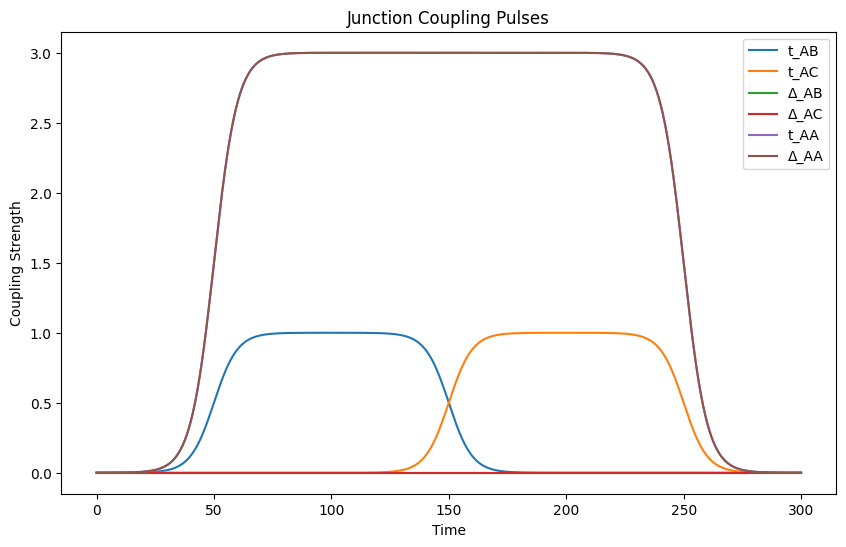

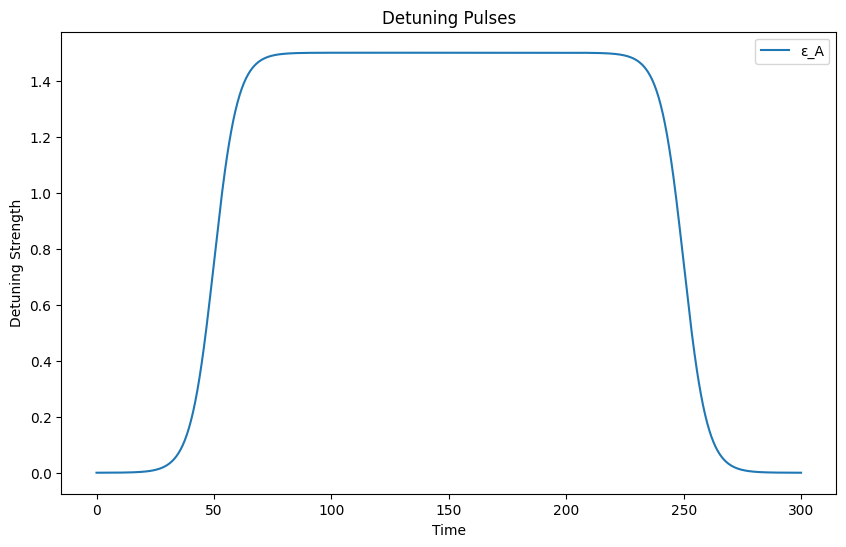

/home/Hishem/miniconda3/envs/myenv/lib/python3.14/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/Hishem/miniconda3/envs/myenv/lib/python3.14/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


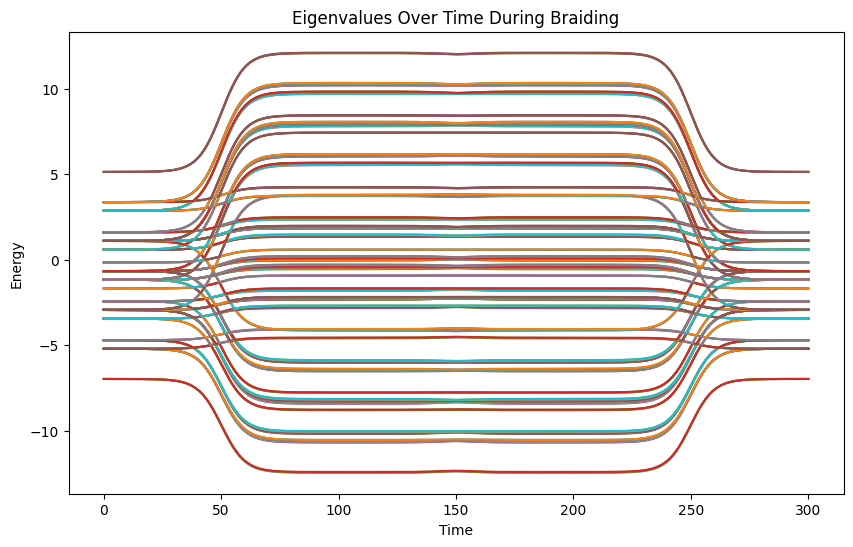

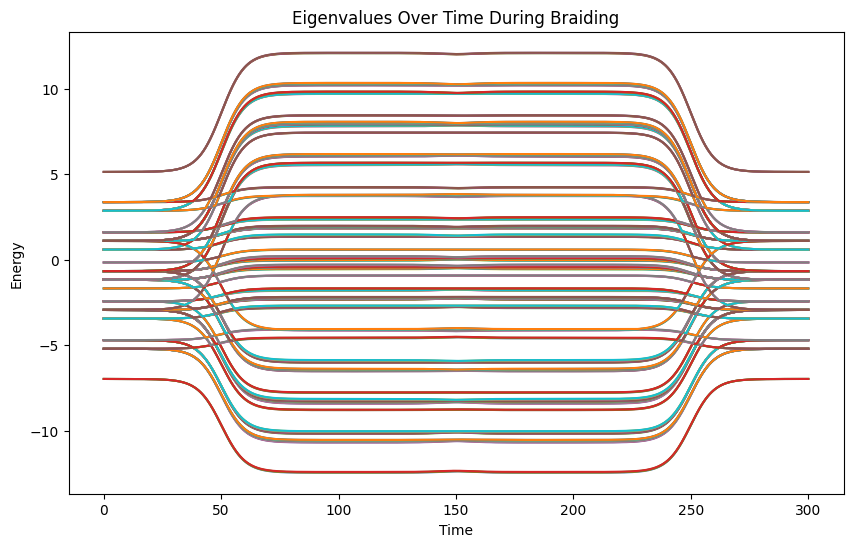

In [10]:


ab_pulse_tJ = [c[0][2] for c in couplings]
ab_pulse_dJ = [c[0][3] for c in couplings]
ac_pulse_tJ = [c[1][2] for c in couplings]
ac_pulse_dJ = [c[1][3] for c in couplings]
aa_pulse_tJ = [c[2][2] for c in couplings]
aa_pulse_dJ = [c[2][3] for c in couplings]
# bc_pulse_tJ = [c[1][2] for c in couplings]
# bc_pulse_dJ = [c[1][3] for c in couplings]
#plot pulses
plt.figure(figsize=(10,6))
plt.plot(time_array, ab_pulse_tJ, label='t_AB')
plt.plot(time_array, ac_pulse_tJ, label='t_AC')
plt.plot(time_array, ab_pulse_dJ, label='Δ_AB')
plt.plot(time_array, ac_pulse_dJ, label='Δ_AC')
plt.plot(time_array, aa_pulse_tJ, label='t_AA')
plt.plot(time_array, aa_pulse_dJ, label='Δ_AA')
# plt.plot(time_array, bc_pulse_tJ, label='t_BC')
# plt.plot(time_array, bc_pulse_dJ, label='Δ_BC')

plt.xlabel('Time')
plt.ylabel('Coupling Strength')
plt.title('Junction Coupling Pulses')
plt.legend()
plt.show()

#plot detuning pulses
plt.figure(figsize=(10,6))
# plt.plot(time_array, eps_detune_val, label='ε_A')
plt.plot(time_array, [d[0][2] for d in eps_detune], label='ε_A')
# plt.plot(time_array, [d[1][2] for d in eps_detune], label='ε_B')
# plt.plot(time_array, [d[2][2] for d in eps_detune], label='ε_C')
plt.xlabel('Time')
plt.ylabel('Detuning Strength')
plt.title('Detuning Pulses')
plt.legend()
plt.show()

# eigvals_cut = eigvals[:, :8]
even_vals_cut = even_vals#[:, :8]
odd_vals_cut = odd_vals#[:, :8]

#plot eigenvalues over time
plt.figure(figsize=(10,6))
for i in range(even_vals_cut.shape[1]):
    plt.plot(time_array, even_vals_cut[:,i], label=f'Even State {i}')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Eigenvalues Over Time During Braiding')
# plt.legend(frameon=False)
plt.show()  
plt.figure(figsize=(10,6))
for i in range(odd_vals_cut.shape[1]):
    plt.plot(time_array, odd_vals_cut[:,i], label=f'Odd State {i}')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Eigenvalues Over Time During Braiding')
# plt.legend(frameon=False)
plt.show()  

# for i in range(14):
#     even_vals_cut = even_vals[:, i*8:8*(i+1)]
#     odd_vals_cut = odd_vals[:, i*8:8*(i+1)]   

#     plt.figure(figsize=(10,6))
#     for j in range(even_vals_cut.shape[1]):
#         state_idx = i*8 + j
#         plt.plot(time_array, even_vals_cut[:,j], label=f'Even State {state_idx}')
#     plt.xlabel('Time')
#     plt.ylabel('Energy')
#     plt.title('Eigenvalues Over Time During Braiding')
#     plt.legend(frameon=False)
#     plt.show()  
#     plt.figure(figsize=(10,6))
#     for j in range(odd_vals_cut.shape[1]):
#         state_idx = i*8 + j
#         plt.plot(time_array, odd_vals_cut[:,j], label=f'Odd State {state_idx}')
#     plt.xlabel('Time')
#     plt.ylabel('Energy')
#     plt.title('Eigenvalues Over Time During Braiding')
#     plt.legend(frameon=False)
#     plt.show()  



# Verify the results

In [11]:

def evolve_basis(Total_time, time_steps, params, couplings, detunes, P_even):

    t_val, U_val, eps_val, Delta_val = params
    time_array = np.linspace(0, Total_time, time_steps)

    # --- Initial Hamiltonian ---
    H0_full = hamiltonian(
        n_sites, dupes, t_val, U_val, eps_val, Delta_val,
        couplings=couplings[0],
        eps_detune=detunes[0],
        operators=operators
    )

    # Project to even parity
    H0 = P_even.conj().T @ H0_full @ P_even

    eigvals_0, eigvecs_0 = np.linalg.eigh(H0)

    cutoff = 2  
    phi_prev = eigvecs_0[:, :cutoff].copy()
    phi0 = phi_prev.copy()

    U = np.eye(cutoff, dtype=complex)

    # --- Kato evolution ---
    for i in tqdm(range(1, len(time_array))):

        H_full = hamiltonian(
            n_sites, dupes, t_val, U_val, eps_val, Delta_val,
            couplings=couplings[i],
            eps_detune=detunes[i],
            operators=operators
        )

        H = P_even.conj().T @ H_full @ P_even

        _, eigvecs = np.linalg.eigh(H)
        phi = eigvecs[:, :cutoff]

        # Overlap matrix
        M = phi_prev.conj().T @ phi

        # Gauge fixing
        Uu, _, Vh = np.linalg.svd(M)
        M_gauge = Vh.conj().T @ Uu.conj().T

        U = M_gauge @ U
        phi_prev = phi

    return phi0, phi_prev, U


P_op = total_parity(operators['num'])
P_eigvals, P_eigvecs = np.linalg.eigh(P_op)
even_idxs = np.where(P_eigvals > 0)[0]
P_even = P_eigvecs[:, even_idxs]

phi0, phi, U_berry = evolve_basis(Total_time, n_time_steps, pars, couplings, eps_detune, P_even)

# print("Initial ground states shape:", phi0.shape)
# print("phi0:", phi0)
# print("Final ground states shape:", phi.shape)
# print("phi:", phi)
print("Braiding unitary shape:", U_berry.shape)

#Calculate U_berry eigvals
print("Braiding unitary eigenvalues:")
U_eigvals = np.linalg.eigvals(U_berry)
for val in U_eigvals:
    angle = np.angle(val)
    print(f"Eigenvalue: {val:.4f}, Angle: {angle:.4f} rad, {angle*180/np.pi:.2f}°")



100%|██████████| 999/999 [00:29<00:00, 34.02it/s]

Braiding unitary shape: (2, 2)
Braiding unitary eigenvalues:
Eigenvalue: -1.0000+0.0000j, Angle: 3.1416 rad, 180.00°
Eigenvalue: 1.0000+0.0000j, Angle: 0.0000 rad, 0.00°


In [12]:

def strip_global_phase(U):
    return U / np.sqrt(np.linalg.det(U))

U_phys = strip_global_phase(U_berry)
print(U_berry)
print(np.angle(np.linalg.eigvals(U_berry)))
print("U (phase stripped):")
print(U_phys)

print("Eigenphases:")
print(np.angle(np.linalg.eigvals(U_phys)))


sx = np.array([[0,1],[1,0]], dtype=complex)
sy = np.array([[0,-1j],[1j,0]], dtype=complex)
sz = np.array([[1,0],[0,-1]], dtype=complex)

theta = np.arccos(np.real(np.trace(U_phys))/2)
print("theta =", theta)

for name, s in zip(["X","Y","Z"], [sx, sy, sz]):
    comp = 1j * np.trace(U_phys @ s) / (2*np.sin(theta))
    print(f"{name} component: {comp:.4f}")

[[-0.33670343+0.j -0.94161075+0.j]
 [-0.94161075+0.j  0.33670343+0.j]]
[3.14159265 0.        ]
U (phase stripped):
[[0.+0.33670343j 0.+0.94161075j]
 [0.+0.94161075j 0.-0.33670343j]]
Eigenphases:
[ 1.57079633 -1.57079633]
theta = 1.5707963267948966
X component: -0.9416+0.0000j
Y component: -0.0000-0.0000j
Z component: -0.3367+0.0000j


In [13]:
np.linalg.norm(U_berry.conj().T @ U_berry - np.eye(2)) #Close to zero -> numerically clean

np.float64(1.0052069764379397e-13)

Max leakage during braiding: 1.0000000000000038


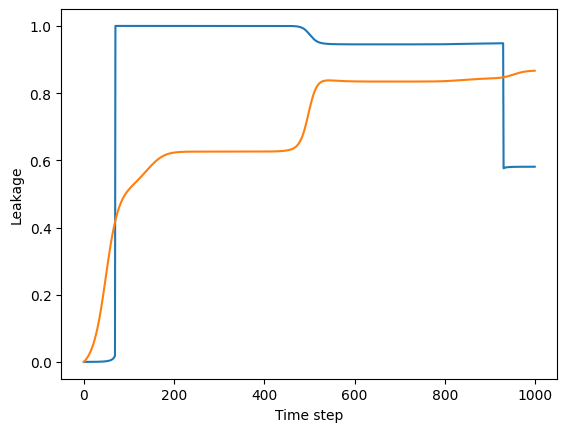

In [14]:
def check_adiabatic_leakage(time_array,eigvals,eigvecs,cutoff):
    """
    Checks leakage out of instantaneous ground space.

    Returns:
        leakages[t, a] = leakage of initial ground state a at time t
    """

    dt = time_array[1] - time_array[0]
    dim = eigvecs.shape[1]
    Ng = cutoff
    I = np.eye(dim)

    psi0 = eigvecs[0][:, :Ng]

    leakages = np.zeros((len(time_array), Ng))

    # Evolve each ground state independently
    for a in range(Ng):
        psi = psi0[:, a].copy()

        for t in range(len(time_array)):
            # Instantaneous ground projector
            Phi_t = eigvecs[t][:, :Ng]
            P0 = Phi_t @ Phi_t.conj().T

            # Leakage
            leak = np.linalg.norm((I - P0) @ psi)
            leakages[t, a] = leak

            # Time evolve (except last step)
            if t < len(time_array) - 1:
                H_diag = np.diag(eigvals[t])
                U_dt = expm(-1j * H_diag * dt)
                psi = eigvecs[t] @ (U_dt @ (eigvecs[t].conj().T @ psi))

    return leakages

leakages = check_adiabatic_leakage(time_array, eigvals, eigvecs, cutoff=2)
print("Max leakage during braiding:", np.max(leakages))

plt.plot(leakages)
# plt.yscale("log")
plt.xlabel("Time step")
plt.ylabel("Leakage")
plt.show()


In [15]:
steps = [0, n_time_steps//3, 2*n_time_steps//3, n_time_steps-1]

t, U, eps, Delta = pars

H0 = hamiltonian(n_sites, dupes, t, U, eps, Delta, couplings=couplings[0], eps_detune=eps_detune[0], operators=operators)
H1 = hamiltonian(n_sites, dupes, t, U, eps, Delta, couplings=couplings[steps[1]], eps_detune=eps_detune[steps[1]], operators=operators)
H2 = hamiltonian(n_sites, dupes, t, U, eps, Delta, couplings=couplings[steps[2]], eps_detune=eps_detune[steps[2]], operators=operators)
H3 = hamiltonian(n_sites, dupes, t  , U, eps, Delta, couplings=couplings[steps[3]], eps_detune=eps_detune[steps[3]], operators=operators)
P_full = total_parity(operators['num'])

for i in range(4):
    Hi = [H0, H1, H2, H3][i]
    comm_norm = np.linalg.norm(Hi @ P_full - P_full @ Hi)
    print(f"Comm norm [H{i}, P]: {comm_norm:.3e}")

phi0_full = P_even @ phi0   # shape (512, 2)

# Expectation of parity
P_exp = np.diag(phi0_full.conj().T @ P_full @ phi0_full)
print(P_exp)

Comm norm [H0, P]: 0.000e+00
Comm norm [H1, P]: 0.000e+00
Comm norm [H2, P]: 0.000e+00
Comm norm [H3, P]: 0.000e+00
[1.+0.j 1.+0.j]


In [16]:
def strip_global_phase(U):
    return U / np.sqrt(np.linalg.det(U))

U_phys = strip_global_phase(U_berry)

print("U (phase stripped):")
print(U_phys)

print("Eigenphases:")
print(np.angle(np.linalg.eigvals(U_phys)))

U (phase stripped):
[[0.+0.33670343j 0.+0.94161075j]
 [0.+0.94161075j 0.-0.33670343j]]
Eigenphases:
[ 1.57079633 -1.57079633]


In [17]:
sx = np.array([[0,1],[1,0]], dtype=complex)
sy = np.array([[0,-1j],[1j,0]], dtype=complex)
sz = np.array([[1,0],[0,-1]], dtype=complex)

theta = np.arccos(np.real(np.trace(U_berry))/2)
print("theta =", theta)

for name, s in zip(["X","Y","Z"], [sx, sy, sz]):
    comp = 1j * np.trace(U_berry @ s) / (2*np.sin(theta))
    print(f"{name} component:", comp)

theta = 1.5707963267948992
X component: (-0-0.9416107489190435j)
Y component: (1.4432899320127035e-15+0j)
Z component: (-0-0.3367034266534703j)


# Explore subsystem A

In [18]:
t_val, U_val, eps_val, Delta_val = pars

eps_detune_val = t_val[0]*1.5

tJ, dJ = 5.0, 5.0

def evolve_subsystem_A(Total_time, time_steps, n, dupes, params, tJ, dJ, eps_detune_val):
    #Calculate the operators for only subsystem A
    big_N = n * dupes
    cre, ann, num = precompute_ops(big_N)
    operators['cre'] = cre
    operators['ann'] = ann
    operators['num'] = num
    hop_ops = {}
    pair_ops = {}
    dens_ops = {}
    for i in range(dupes):
        off = i * n
        for j in range(n-1):
            a, b = off+j, off+j+1
            hop_ops[(a,b)] = cre[a] @ ann[b] + ann[a] @ cre[b]
            pair_ops[(a,b)] = cre[a] @ cre[b] + ann[b] @ ann[a]
            dens_ops[(a,b)] = num[a] @ num[b]
    operators['hop'] = hop_ops
    operators['pair'] = pair_ops
    operators['dens'] = dens_ops



    
    t_val, U_val, eps_val, Delta_val = params
    
    print("t values:", t_val)
    print("U values:", U_val)
    print("Eps values:", eps_val)
    print("Delta values:", Delta_val)
    print("tJ =", tJ, "dJ =", dJ)
    print("eps_detune_val =", eps_detune_val)
    width = Total_time / 3
    s = 20/width#

    dT, dD = 5, 5  # Add perturbations to intra PMM couplings

    #System setup
    A, B, C = 0, 1, 2
    outer, middle, inner = 2, 1, 0

    time_array = np.linspace(0, Total_time, time_steps)
    eps_detune_min = eps_val[0]
    eps_detune = []
    couplings = []
    for i in range(len(time_array)):
        t = time_array[i]

        #Tune chemical potentials for detuning
        detune_A = simple_delta_pulse(t, Total_time/2, 2*width, s, eps_detune_val, 0.0)
        
        tj_pulse_AB = simple_delta_pulse(t, Total_time/3, width, s, tJ, 0.0)
        tj_pulse_AC = simple_delta_pulse(t, 2*Total_time/3, width, s, tJ, 0.0)

        eps_detune.append([[A, outer, detune_A]])

        tj_pulse_A = (tj_pulse_AB + tj_pulse_AC) / np.linalg.norm(2*tJ) * (tJ + dT) #- tJ
        dj_pulse_A = (tj_pulse_AB + tj_pulse_AC) / np.linalg.norm(2*tJ) * (dJ + dD) #- dJ

        coups = [[(A, inner), (A, middle), tj_pulse_A, dj_pulse_A],
                 [(A, middle), (A, outer), tj_pulse_A, dj_pulse_A]
                 ]
        couplings.append(coups)

    dim = 2**big_N

    eigvals = np.zeros((time_steps, dim), dtype=complex)
    eigvecs = np.zeros((time_steps, dim, dim), dtype=complex)
    gap = np.zeros(time_steps, dtype=complex)


    for i in tqdm(range(len(time_array))):

        H_t = hamiltonian(n, dupes, t_val, U_val, eps_val, Delta_val,
                          couplings=couplings[i],
                          eps_detune=eps_detune[i],
                          operators=operators)
        if i == 0:
            print("Hamiltonian at t=0:")
            print(H_t)
        eigvals_t, eigvecs_t = np.linalg.eigh(H_t)
        eigvals[i] = eigvals_t
        eigvecs[i] = eigvecs_t
        gap[i] = eigvals_t[1] - eigvals_t[0]

    return time_array, couplings, eps_detune, eigvals, eigvecs, gap, operators

time_array_A, couplings_A, eps_detune_A, eigvals_A, eigvecs_A, gap_A, operators_A = evolve_subsystem_A(Total_time, n_time_steps, 3, 1, pars, tJ, dJ, eps_detune_val)

t values: [1. 1.]
U values: [0.1 0.1]
Eps values: [-0.10097739030086553, -0.6071436946690216, -0.0032830574591187892]
Delta values: [1.001265238594651, 1.0015039227972797]
tJ = 5.0 dJ = 5.0
eps_detune_val = 1.5


  0%|          | 0/1000 [00:00<?, ?it/s]

Hamiltonian at t=0:
[[-5.08052988e-01+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   1.00173091e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   1.00149223e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j -6.08121085e-01+0.j -1.00022699e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  1.00149223e+00+0.j]
 [ 0.00000000e+00+0.j  1.00022699e+00+0.j -1.00909293e-01+0.j
   0.00000000e+00+0.j -1.00022699e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 1.00173091e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
  -1.00977390e-01+0.j  0.00000000e+00+0.j -1.00022699e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  1.00022699e+00+0.j
   0.00000000e+00+0.j -5.07075598e-01+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  1.00173091e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   1.00022699e+00+0.j  0.00000000e+00+0.j -6.07143695e-01+0.j
  -1.00022699e+00+0.j

100%|██████████| 1000/1000 [00:00<00:00, 31280.47it/s]


In [13]:
def calculate_parities(eigenvecs, eigenvals, P):
        parities = np.sum(eigenvecs.conj().T @ P @ eigenvecs, axis=0).real
        even_idxs = np.where(parities > 0)[0]
        odd_idxs = np.where(parities < 0)[0]

        even_energies = eigenvals[even_idxs]
        odd_energies = eigenvals[odd_idxs]

        even_vecs = eigenvecs[:, even_idxs]
        odd_vecs = eigenvecs[:, odd_idxs]

        return even_energies, odd_energies, even_vecs, odd_vecs
def collect_parity_arrays(eigvals, eigvecs, time_array):
    dim = eigvecs.shape[1]
    dimhalf = eigvecs.shape[1] // 2

    even_vals = np.zeros((len(time_array), dimhalf), dtype=complex)
    odd_vals = np.zeros((len(time_array), dimhalf), dtype=complex)
    even_vecs = np.zeros((len(time_array), dim, dimhalf), dtype=complex)
    odd_vecs = np.zeros((len(time_array), dim, dimhalf), dtype=complex)



    for idx in tqdm(range(len(time_array))):
        even_energies, odd_energies, even_vecs_t, odd_vecs_t = calculate_parities(eigvecs[idx], eigvals[idx], total_parity(operators['num']))
        even_vals[idx,:len(even_energies)] = even_energies
        odd_vals[idx,:len(odd_energies)] = odd_energies
        even_vecs[idx,:,:len(even_energies)] = even_vecs_t
        odd_vecs[idx,:,:len(odd_energies)] = odd_vecs_t


    return even_vals, odd_vals, even_vecs, odd_vecs
eigvals_even_A, eigvals_odd_A, eigvecs_even_A, eigvecs_odd_A = collect_parity_arrays(eigvals_A, eigvecs_A, range(len(time_array_A)))

# # Plot eigenvalues over time for subsystem A
plt.figure(figsize=(10,6))
for i in range(len(eigvals_even_A[0])):
    plt.plot(time_array_A, eigvals_even_A[:,i], label=f'Even State {i}')
for i in range(len(eigvals_odd_A[0])):
    plt.plot(time_array_A, eigvals_odd_A[:,i], label=f'Odd State {i}', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Eigenvalues Over Time During Braiding (Subsystem A)')
plt.legend(frameon=False)
plt.show()


#plot couplings for subsystem A
aa_pulse_tJ_A = [c[0][2] for c in couplings_A]
aa_pulse_dJ_A = [c[0][3] for c in couplings_A]
plt.figure(figsize=(10,6))
plt.plot(time_array_A, aa_pulse_tJ_A, label='t_AA')
plt.plot(time_array_A, aa_pulse_dJ_A, label='Δ_AA')
plt.xlabel('Time')
plt.ylabel('Coupling Strength')
plt.title('Subsystem A Coupling Pulses')
plt.legend()
plt.show()

#plot detuning pulses for subsystem A
plt.figure(figsize=(10,6))
plt.plot(time_array_A, [d[0][2] for d in eps_detune_A], label='ε_A')
plt.xlabel('Time')      
plt.ylabel('Detuning Strength')
plt.title('Subsystem A Detuning Pulses')
plt.legend()
plt.show()
print(eps_detune_A[0])

NameError: name 'eigvals_A' is not defined

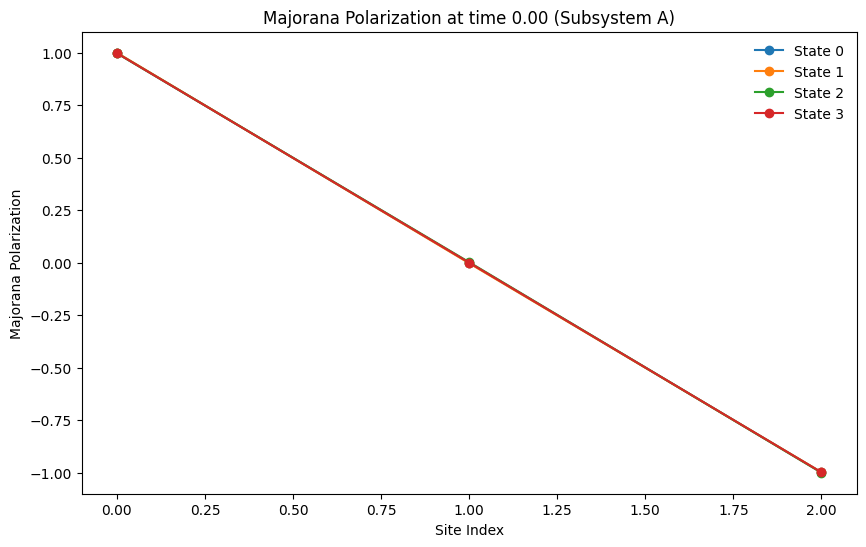

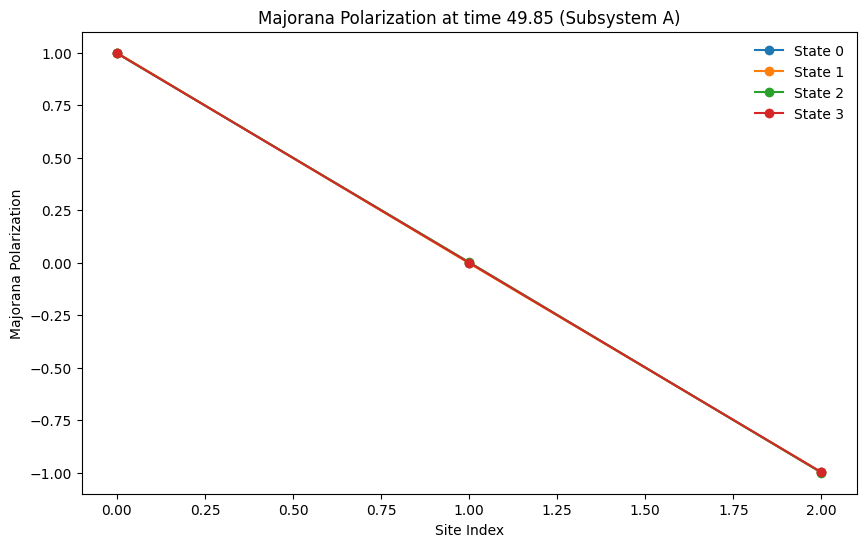

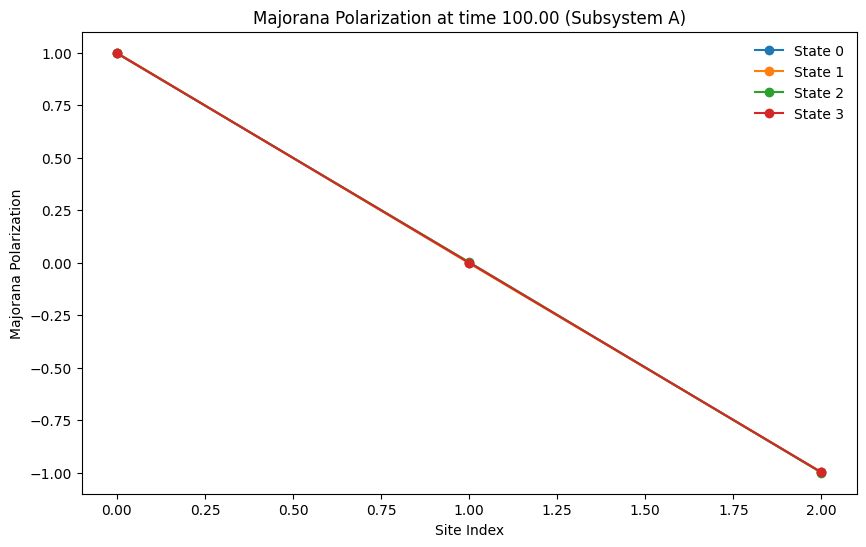

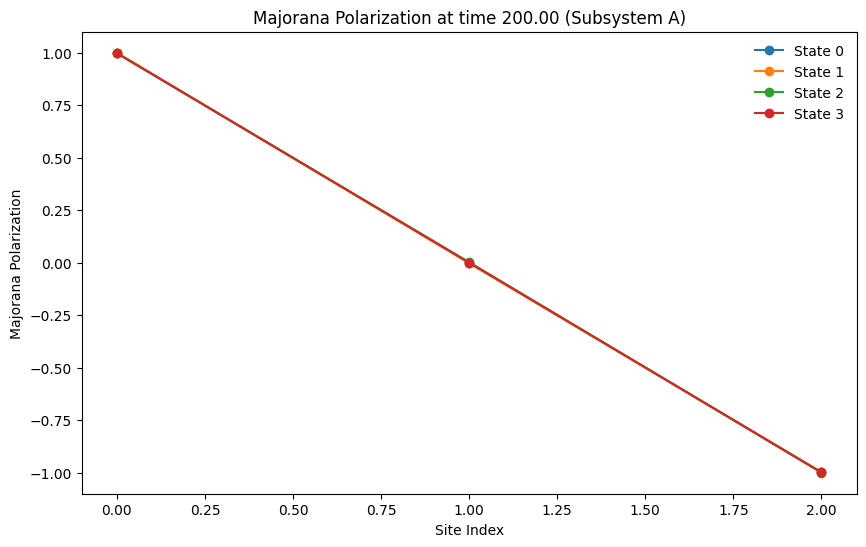

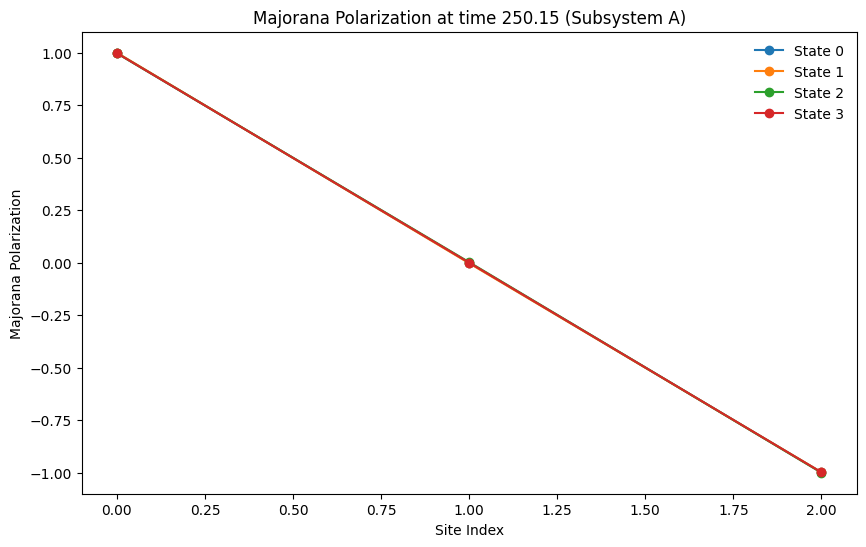

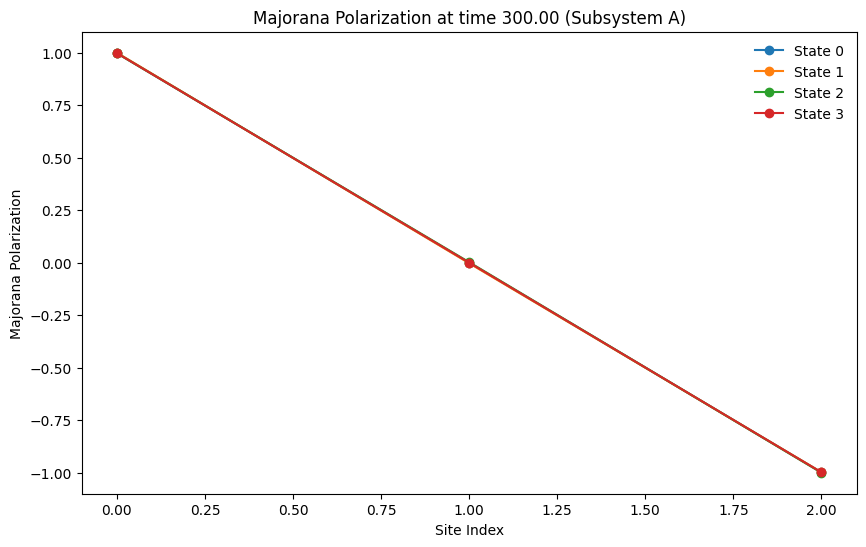

In [20]:
def construct_Gamma_operators(j,n):
    """Construct the Majorana operators Γ^s_j for site j in a chain of n sites."""
    f_dag_j, f_j = creation_annihilation(j, n)
    Gamma_1 = f_dag_j + f_j
    Gamma_2 = 1j * (f_dag_j - f_j)
    return Gamma_1, Gamma_2


def majorana_polarization(even_vecs, odd_vecs, n):
    M = np.zeros((even_vecs.shape[1], n), dtype=np.complex128)

    for j in range(n):
        Gamma_1, Gamma_2 = construct_Gamma_operators(j, n)
        for i in range(even_vecs.shape[1]):
            e = even_vecs[:,i]
            o = odd_vecs[:,i]
            term1 = np.vdot(o, Gamma_1 @ e)
            term2 = np.vdot(o, Gamma_2 @ e)
            M[i, j] = term1**2 + term2**2
    return M

# majorana_ops_A = majorana_operators(3)
times = [0, n_time_steps//6, n_time_steps//3, 2*n_time_steps//3, 5*n_time_steps//6, n_time_steps-1]

for idx, time_idx in enumerate(times):
    M_A = majorana_polarization(eigvecs_even_A[idx], eigvecs_odd_A[idx], 3)
    plt.figure(figsize=(10,6))
    for i in range(M_A.shape[0]):
        plt.plot(range(3), M_A[i], 'o-', label=f'State {i}')
    plt.xlabel('Site Index')
    plt.ylabel('Majorana Polarization')
    plt.title(f'Majorana Polarization at time {time_array_A[time_idx]:.2f} (Subsystem A)')
    plt.legend(frameon=False)
    plt.show()

# Initial Subsystems

In [21]:
def subsystem_hamiltonian(n_sites, dupes, pars, couplings=(), eps_detune=None, operators=operators):
    t_val, U_val, eps_val, Delta_val = pars
    H = hamiltonian(n_sites, dupes, t_val, U_val, eps_val, Delta_val, couplings=couplings, eps_detune=eps_detune,operators=operators)
    eigvals, eigvecs = np.linalg.eigh(H)
    

    #calculate parities
    even_energies, odd_energies, even_vecs, odd_vecs = calculate_parities(eigvecs, eigvals, total_parity(operators['num']))
    return H, eigvals, eigvecs, even_energies, odd_energies, even_vecs, odd_vecs


In [22]:
#SubsysA
eigvals_A_t0, eigvecs_A_t0 ,eigvals_even_A_t0, eigvals_odd_A_t0, even_vecs_A_t0, odd_vecs_A_t0 = eigvals_A[0], eigvecs_A[0] ,eigvals_even_A[0], eigvals_odd_A[0], eigvecs_even_A[0], eigvecs_odd_A[0]

#SubsysB 
H_B, eigvals_B_t0, eigvecs_B_t0, even_energies_B_t0, odd_energies_B_t0, even_vecs_B_t0, odd_vecs_B_t0 = subsystem_hamiltonian(3, 1, pars, couplings=(), eps_detune=None, operators=operators_A)

#SubsysC
H_C, eigvals_C_t0, eigvecs_C_t0, even_energies_C_t0, odd_energies_C_t0, even_vecs_C_t0, odd_vecs_C_t0 = subsystem_hamiltonian(3, 1, pars, couplings=(), eps_detune=None, operators=operators_A)


/home/Hishem/miniconda3/envs/myenv/lib/python3.14/site-packages/numpy/ma/core.py:3463: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/Hishem/miniconda3/envs/myenv/lib/python3.14/site-packages/matplotlib/transforms.py:2876: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


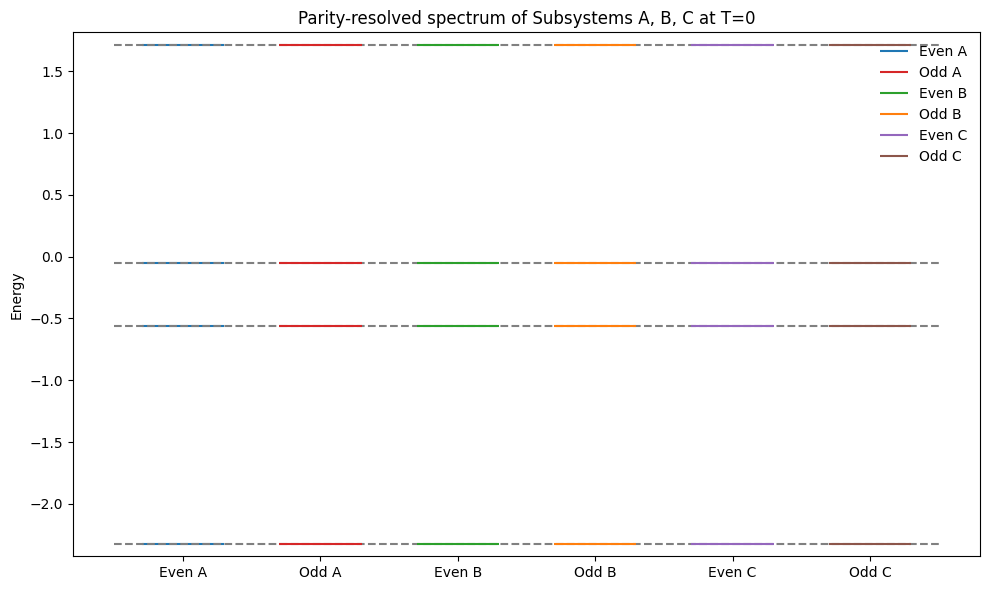

In [23]:
#plot eigenvalues for subsystems A, B, C
plt.figure(figsize=(10,6))
for i in range(len(eigvals_even_A_t0)):
    plt.hlines(eigvals_even_A_t0[i], -0.3, 0.3, color='tab:blue', label='Even A' if i==0 else "")
    plt.hlines(eigvals_even_A_t0[i], -0.5, 5.5, color='gray', linestyles='--')
for i in range(len(eigvals_odd_A_t0)):
    plt.hlines(eigvals_odd_A_t0[i], 0.7, 1.3, color='tab:red', label='Odd A' if i==0 else "")
for i in range(len(even_energies_B_t0)):
    plt.hlines(even_energies_B_t0[i], 1.7, 2.3, color='tab:green', label='Even B' if i==0 else "")
for i in range(len(odd_energies_B_t0)):
    plt.hlines(odd_energies_B_t0[i], 2.7, 3.3, color='tab:orange', label='Odd B' if i==0 else "")  
for i in range(len(even_energies_C_t0)):
    plt.hlines(even_energies_C_t0[i], 3.7, 4.3, color='tab:purple', label='Even C' if i==0 else "")
for i in range(len(odd_energies_C_t0)):
    plt.hlines(odd_energies_C_t0[i], 4.7, 5.3, color='tab:brown', label='Odd C' if i==0 else "")
plt.ylim(min(eigvals_even_A_t0.min(), even_energies_B_t0.min(), even_energies_C_t0.min()) - 0.1, max(eigvals_odd_A_t0.max(), odd_energies_B_t0.max(), odd_energies_C_t0.max()) + 0.1)
plt.xticks([0, 1, 2, 3, 4, 5], ["Even A", "Odd A", "Even B", "Odd B", "Even C", "Odd C"]) 
plt.ylabel("Energy")
plt.title(f"Parity-resolved spectrum of Subsystems A, B, C at T=0")    
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# Time evolution and Verification


In [6]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import expm_multiply
@njit
def adiabaticity_parameter(H_curr, H_prev, ground_vec, excited_vec, ground_energy, excited_energy, dt):
    ΔH = (H_curr - H_prev) / dt
    overlap = np.abs(np.vdot(excited_vec, ΔH @ ground_vec))
    ΔE = (excited_energy - ground_energy)**2 + 1e-10
    return overlap / ΔE, np.linalg.norm(ΔH)/np.abs(ground_energy)

def get_coupling_information(Total_time, time_steps, params, tJ, dJ, eps_detune_val,operators=operators):

    #Base parameters
    t_val, U_val, eps_val, Delta_val = params
    width = Total_time / 3
    s = 20/width#

    dT, dD = 5, 5  # Add perturbations to intra PMM couplings

    #System setup
    A, B, C = 0, 1, 2
    outer, middle, inner = 2, 1, 0

    time_array = np.linspace(0, Total_time, time_steps)
    eps_detune_min = eps_val[0]
    eps_detune = []
    couplings = []
    for i in range(len(time_array)):
        t = time_array[i]

        #Tune chemical potentials for detuning
        detune_A = simple_delta_pulse(t, Total_time/2, 2*width, s, eps_detune_val, 0.0)
        
        tj_pulse_AB = simple_delta_pulse(t, Total_time/3, width, s, tJ, 0.0)
        tj_pulse_AC = simple_delta_pulse(t, 2*Total_time/3, width, s, tJ, 0.0)

        eps_detune.append([[A, outer, detune_A]])

        tj_pulse_A = (tj_pulse_AB + tj_pulse_AC) / np.linalg.norm(2*tJ) * (tJ + dT)  #+ t_val[0]
        dj_pulse_A = (tj_pulse_AB + tj_pulse_AC) / np.linalg.norm(2*tJ) * (dJ + dD)  #+ Delta_val[0]

        coups = [[(A, inner), (B, inner), tj_pulse_AB, 0.0],
                 [(C, inner), (A, inner), tj_pulse_AC, 0.0],
                 [(A, inner), (A, middle), tj_pulse_A, dj_pulse_A],
                 [(A, middle), (A, outer), tj_pulse_A, dj_pulse_A]
                 ]
        couplings.append(coups)

    return couplings, eps_detune, time_array

def evolve_time_ev_operator(Total_time, time_steps, params, couplings, eps_detunes, N , operators=operators):
    #Base parameters
    t_val, U_val, eps_val, Delta_val = params


    dim = 2**N
    eigvals = np.zeros((time_steps, dim), dtype=complex)
    eigvecs = np.zeros((time_steps, dim, dim), dtype=complex)
    adiabaticity_storage = np.zeros(time_steps-1, dtype=complex)
    deltaH = np.zeros_like(adiabaticity_storage)

    time_array = np.linspace(0, Total_time, time_steps)
    dt = time_array[1] - time_array[0]

    U_op = np.eye(dim, dtype=complex)
    
    H_prev = hamiltonian(3, 3, t_val, U_val, eps_val, Delta_val,
                          couplings=couplings[0],
                          eps_detune=eps_detunes[0],
                          operators=operators)
    
    for i in tqdm(range(time_steps)):
        H_t = hamiltonian(n_sites, dupes, t_val, U_val, eps_val, Delta_val,
                          couplings=couplings[i],
                          eps_detune=eps_detunes[i],
                          operators=operators)
        H_t = 0.5 * (H_t + H_t.conj().T)

        eigvals_t, eigvecs_t = np.linalg.eigh(H_t)
        eigvals[i] = eigvals_t
        eigvecs[i] = eigvecs_t

        U_step = eigvecs_t @ np.diag(np.exp(-1j * eigvals_t * dt)) @ eigvecs_t.conj().T

        U_op = U_step @ U_op

        if i > 0:
            ground_vec = eigvecs_t[:, 0]
            excited_vec = eigvecs_t[:, 8]
            ground_energy = eigvals_t[0]
            excited_energy = eigvals_t[8]
            ground_vec = np.ascontiguousarray(ground_vec)
            excited_vec = np.ascontiguousarray(excited_vec)
            H_curr = np.ascontiguousarray(H_t)
            H_prev = np.ascontiguousarray(H_prev)

            adiabaticity_storage[i-1], deltaH[i-1] = adiabaticity_parameter(H_curr, H_prev, ground_vec, excited_vec, ground_energy, excited_energy, dt)
        H_prev = H_t

    return time_array, couplings, eps_detune, eigvals, eigvecs, U_op, adiabaticity_storage, deltaH


Total_time = 273.0 ## FROM FINDING AT T=200, Phase = 0.574, T=200* TargetPhase/CurrentPhase = 200*0.785/0.574 = 273.0
n_time_steps = 1000
tJ = t_couple[0]
dJ = delta_couple[0]
eps_detune_val = tJ*1.5
operators = precompute_operators(9)                                                                                                               
couplings, eps_detune, time_array = get_coupling_information(Total_time, n_time_steps, pars, tJ, dJ, eps_detune_val, operators=operators)
time_array, couplings, eps_detune, eigvals, eigvecs, time_ev_operator, adiabaticity_storage, deltaH = evolve_time_ev_operator(Total_time, n_time_steps, pars, couplings, eps_detune, 9, operators=operators)


100%|██████████| 1000/1000 [03:23<00:00,  4.92it/s]


In [7]:
even_vals, odd_vals, even_vecs, odd_vecs = collect_parity_arrays(eigvals, eigvecs, range(len(time_array)))


100%|██████████| 1000/1000 [01:00<00:00, 16.54it/s]


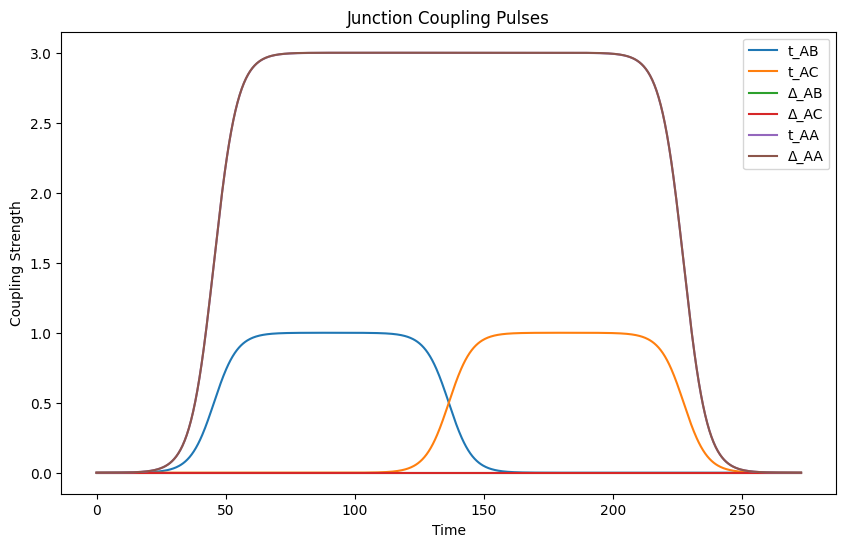

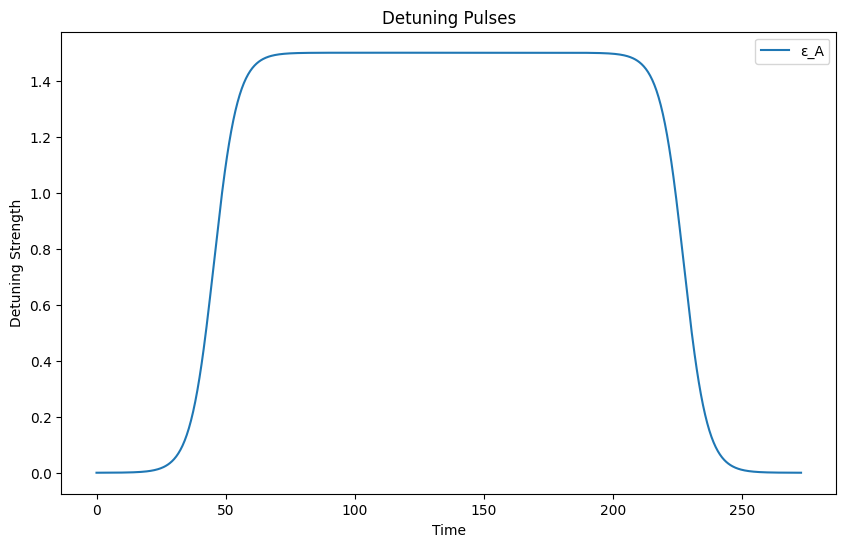

/home/Hishem/miniconda3/envs/myenv/lib/python3.14/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/Hishem/miniconda3/envs/myenv/lib/python3.14/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


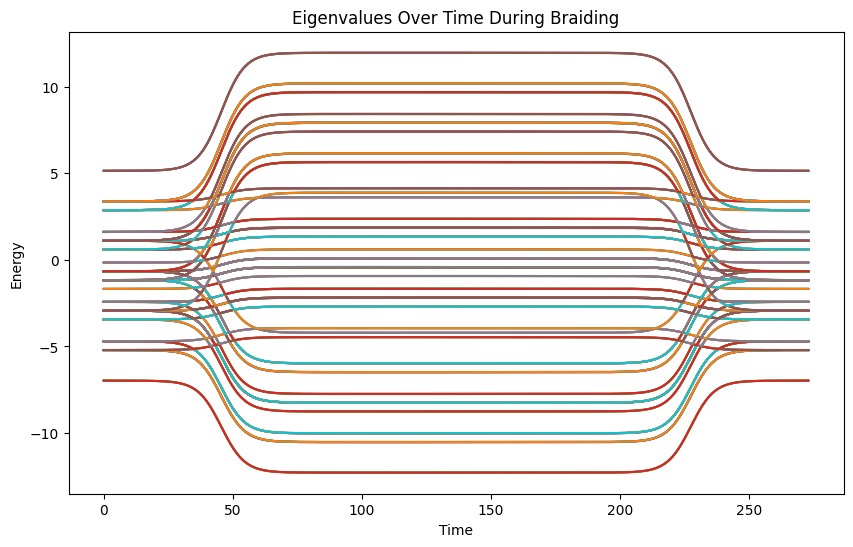

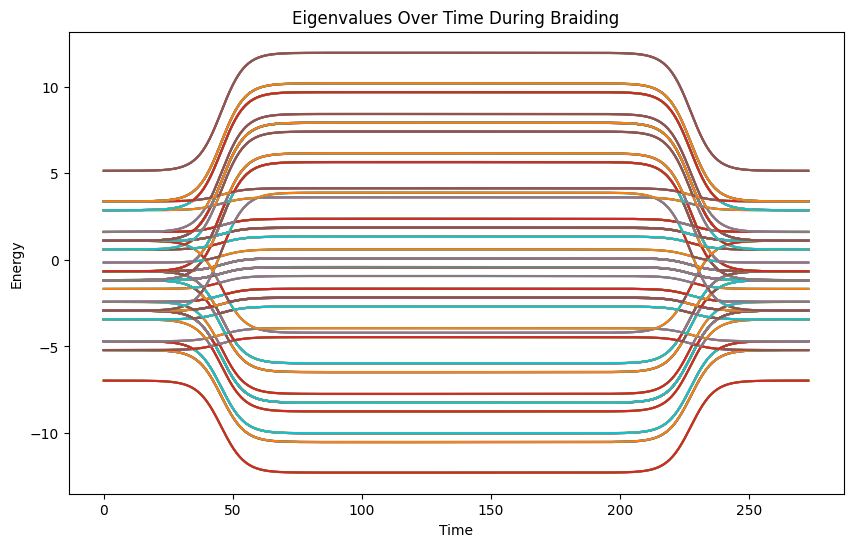

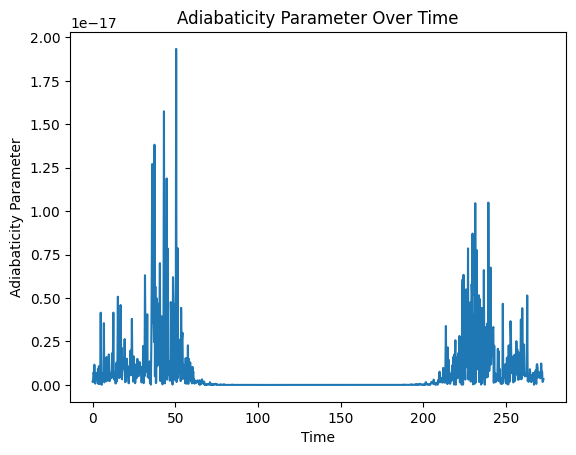

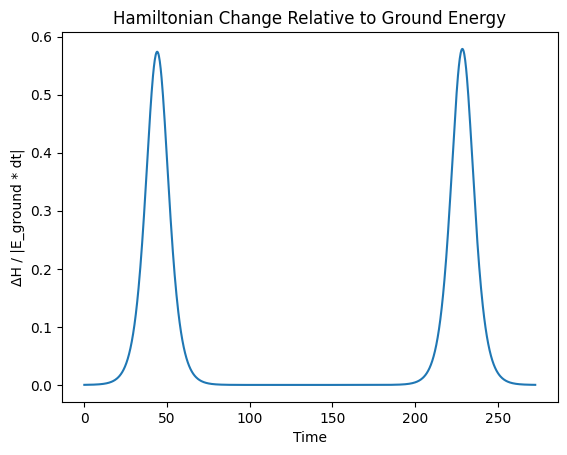

In [8]:


ab_pulse_tJ = [c[0][2] for c in couplings]
ab_pulse_dJ = [c[0][3] for c in couplings]
ac_pulse_tJ = [c[1][2] for c in couplings]
ac_pulse_dJ = [c[1][3] for c in couplings]
aa_pulse_tJ = [c[2][2] for c in couplings]
aa_pulse_dJ = [c[2][3] for c in couplings]

plt.figure(figsize=(10,6))
plt.plot(time_array, ab_pulse_tJ, label='t_AB')
plt.plot(time_array, ac_pulse_tJ, label='t_AC')
plt.plot(time_array, ab_pulse_dJ, label='Δ_AB')
plt.plot(time_array, ac_pulse_dJ, label='Δ_AC')
plt.plot(time_array, aa_pulse_tJ, label='t_AA')
plt.plot(time_array, aa_pulse_dJ, label='Δ_AA')

plt.xlabel('Time')
plt.ylabel('Coupling Strength')
plt.title('Junction Coupling Pulses')
plt.legend()
plt.show()

#plot detuning pulses
plt.figure(figsize=(10,6))
plt.plot(time_array, [d[0][2] for d in eps_detune], label='ε_A')
plt.xlabel('Time')
plt.ylabel('Detuning Strength')
plt.title('Detuning Pulses')
plt.legend()
plt.show()

even_vals_cut = even_vals#[:, :8]
odd_vals_cut = odd_vals#[:, :8]

#plot eigenvalues over time
plt.figure(figsize=(10,6))
for i in range(even_vals_cut.shape[1]):
    plt.plot(time_array, even_vals_cut[:,i], label=f'Even State {i}')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Eigenvalues Over Time During Braiding')
# plt.legend(frameon=False)
plt.show()  
plt.figure(figsize=(10,6))
for i in range(odd_vals_cut.shape[1]):
    plt.plot(time_array, odd_vals_cut[:,i], label=f'Odd State {i}')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Eigenvalues Over Time During Braiding')
# plt.legend(frameon=False)
plt.show()  
plt.plot(time_array[:-1], adiabaticity_storage)
plt.xlabel("Time")
plt.ylabel("Adiabaticity Parameter")    
plt.title("Adiabaticity Parameter Over Time")
plt.show()


plt.plot(time_array[:-1], deltaH)
plt.xlabel("Time")
plt.ylabel("ΔH / |E_ground * dt|")
plt.title("Hamiltonian Change Relative to Ground Energy")
plt.show()

What im going to do is hopefully this

Step 1: U = exp(-i H dt) @ U (dims 512x512)

Step 2: return U at the end 

Step 3: Take ground state from either even or odd sector:

    - |Psi_gs,1>, |Psi_gs,2>
    - create 2x2 matrix:
        M_ij = <Psi_gs,i | U | Psi_gs,j> 
    - one for even and one for odd

step 4: Verify U ~ \sqrt{Z} (dims 2x2)

step 5: Look at what happens if i use excited states instead of ground states

step 6: If step 4 is verified, check if U(t)γ_BU†(t) = ±γ_C

    - γ_X = ∑_n ^N |e_n><o_n| + |o_n><e_n| ⊗ I_rest (dims 512x512)(where |e_n>, |o_n> are the degenerate ground states in even and odd sectors respectively)
    - More specifically:
        - γ_A =  ∑_n ^N |e_n^A><o_n^A| + |o_n^A><e_n^A| ⊗ I_B ⊗ I_C 
        - γ_B =  JW_A ⊗ ∑_n ^N |e_n^B><o_n^B| + |o_n^B><e_n^B| ⊗ I_C (where JW_A is the Jordan Wigner string for subsystem A - in practise would be Parity operator for subsystem A)
        - γ_C =  JW_A ⊗ JW_B ⊗ ∑_n ^N |e_n^C><o_n^C| + |o_n^C><e_n^C| ⊗ I_rest
    - Then check if U(t)γ_BU†(t) = ±γ_C

In [9]:
# for i in range(n_time_steps):
#     if i % 50 == 0:
#         print(f"Time step {i}/{n_time_steps}, max eigenvalue: {np.max(eigvals[i])}")
print(np.linalg.norm(time_ev_operator.conj().T @ time_ev_operator - np.eye(2**9))) #Check that time evolution operator is unitary (should be close to zero)
print(np.max(eigvals) * Total_time/n_time_steps)  # Check that max eigenvalue * dt is not too large for numerical stability


3.6275820077584684e-12
(3.2644174482391497+0j)


In [10]:
def get_parity_operator(system, operators):
    """
    Returns the parity operator for subsystem A, B, C, or Full.
    P = ∏_i (I - 2 n_i)
    """

    num = operators['num']
    dim = num[0].shape[0]
    I = np.eye(dim, dtype=complex)

    if system == 'A':
        sites = range(0, 3)
    elif system == 'B':
        sites = range(3, 6)
    elif system == 'C':
        sites = range(6, 9)
    elif system == 'Full':
        sites = range(9)
    else:
        raise ValueError("System must be 'A', 'B', 'C', or 'Full'.")

    P = I.copy()
    for i in sites:
        P = P @ (I - 2 * num[i])

    return P
P_A = get_parity_operator('A', operators)
P_B = get_parity_operator('B', operators)
P_C = get_parity_operator('C', operators)
P_full = get_parity_operator('Full', operators)

In [11]:
def parity_2x2_mat(v0,v1, P):
    """
    Given two states v0, v1 and a parity operator P, construct the 2x2 parity matrix:
    M_ij = <v_i|P|v_j>
    """
    M = np.zeros((2,2), dtype=complex)
    M[0,0] = np.vdot(v0, P @ v0)
    M[0,1] = np.vdot(v0, P @ v1)
    M[1,0] = np.vdot(v1, P @ v0)
    M[1,1] = np.vdot(v1, P @ v1)
    return M

v0_even = even_vecs[0,:, 0]
v1_even = even_vecs[0,:, 1]
v0_odd = odd_vecs[0,:, 0]
v1_odd = odd_vecs[0,:, 1]

gs_vec1 = eigvecs[0,:, 0]
gs_vec2 = eigvecs[0,:, 1]
MA = parity_2x2_mat(gs_vec1, gs_vec2, P_A).round(2)
MB = parity_2x2_mat(gs_vec1, gs_vec2, P_B).round(2)
MC = parity_2x2_mat(gs_vec1, gs_vec2, P_C).round(2)
Mfull = parity_2x2_mat(gs_vec1, gs_vec2, P_full).round(2)
print("\nParity matrix for subsystem A (ground states):")
print(MA)
print("\nParity matrix for subsystem B (ground states):")
print(MB)   
print("\nParity matrix for subsystem C (ground states):")
print(MC)
print("\nParity matrix for full system (ground states):")
print(Mfull)

def U_to_subspace(U, v0, v1):
    M = np.zeros((2,2), dtype=complex)

    M[0,0] = np.vdot(v0, U @ v0)
    M[0,1] = np.vdot(v0, U @ v1)
    M[1,0] = np.vdot(v1, U @ v0)
    M[1,1] = np.vdot(v1, U @ v1)
    return M

#Projected to full ground state
U_subs = U_to_subspace(time_ev_operator, gs_vec1, gs_vec2).round(2)
print("\nTime evolution operator projected into ground state subspace:")
print(U_subs)

#projected to even subspace
U_even = U_to_subspace(time_ev_operator, v0_even, v1_even).round(2)
print("\nTime evolution operator projected into even subspace:")
print(U_even)

#projected to odd subspace
U_odd = U_to_subspace(time_ev_operator, v0_odd, v1_odd).round(2)
print("\nTime evolution operator projected into odd subspace:")
print(U_odd)


Parity matrix for subsystem A (ground states):
[[ 1.+0.j -0.+0.j]
 [-0.+0.j -1.+0.j]]

Parity matrix for subsystem B (ground states):
[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]

Parity matrix for subsystem C (ground states):
[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]

Parity matrix for full system (ground states):
[[ 1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j]]

Time evolution operator projected into ground state subspace:
[[ 0.79-0.61j -0.  -0.j  ]
 [ 0.  -0.j    0.59+0.81j]]

Time evolution operator projected into even subspace:
[[ 0.79-0.61j -0.  -0.j  ]
 [-0.  -0.j    0.61+0.79j]]

Time evolution operator projected into odd subspace:
[[ 0.59+0.81j  0.  -0.j  ]
 [-0.  -0.j    0.78-0.63j]]


In [12]:
MA = parity_2x2_mat(gs_vec1, gs_vec2, P_A)
evals_MA, evecs_MA = np.linalg.eig(MA)

U_sub = U_to_subspace(time_ev_operator, gs_vec1, gs_vec2)
U_Abasis = evecs_MA.conj().T @ U_sub @ evecs_MA

phi = np.angle(np.linalg.det(U_Abasis)) / 2
U_rot = U_Abasis * np.exp(-1j * phi)
print("U_sub projected into P_A eigenbasis, cleaned:")
print(U_rot.round(2))
print("Eigenphases (degrees):", np.angle(np.linalg.eigvals(U_rot)) * 180/np.pi)

# Force first diagonal entry to be 1
phase_fix = np.angle(U_rot[0,0])
U_nice = U_rot * np.exp(-1j * phase_fix)

print("U in canonical √Z form:")
print(U_nice.round(2))



U_sub projected into P_A eigenbasis, cleaned:
[[ 0.7-0.72j -0. -0.j  ]
 [-0. -0.j    0.7+0.72j]]
Eigenphases (degrees): [-45.64776779  45.64776779]
U in canonical √Z form:
[[ 1.  -0.j  0.  -0.j]
 [ 0.  -0.j -0.02+1.j]]


In [30]:

P_A = get_parity_operator('A', operators)
P_B = get_parity_operator('B', operators)
P_C = get_parity_operator('C', operators)

def build_gamma(even_vecs, odd_vecs, even_energies, odd_energies, P_X, tol=1e-8, n_pairs=None):

    dim = even_vecs.shape[0]
    gamma = np.zeros((dim, dim), dtype=np.complex128)

    used_odd = set()
    pair_count = 0

    for i in range(even_vecs.shape[1]):

        if n_pairs is not None and pair_count >= n_pairs:
            break

        e = even_vecs[:, i]
        E_e = even_energies[i]

        # Find matching odd state with same energy
        candidates = np.where(np.abs(odd_energies - E_e) < tol)[0]

        # Remove already used odd states
        candidates = [j for j in candidates if j not in used_odd]

        if len(candidates) == 0:
            continue

        # Take first unused match
        j = candidates[0]
        used_odd.add(j)

        o = odd_vecs[:, j]

        # Verify parity
        pe = np.vdot(e, P_X @ e)
        po = np.vdot(o, P_X @ o)

        if not (np.isclose(pe, 1) and np.isclose(po, -1)):
            print(f"Warning: bad parity match at energy {E_e}")

        gamma += np.outer(e, o.conj()) + np.outer(o, e.conj())
        pair_count += 1
    P_sub = gamma @ gamma
    print(np.allclose(P_sub @ gamma, gamma))  # Check that gamma^2 = I

    return gamma
print("Constructing Majorana operators for subsystem A")
gamma_A = build_gamma(even_vecs[0], odd_vecs[0], even_vals[0], odd_vals[0], P_A, n_pairs=4)
print("Constructing Majorana operators for subsystem B")
gamma_B = build_gamma(even_vecs[0], odd_vecs[0], even_vals[0], odd_vals[0], P_B, n_pairs=4)
print("Constructing Majorana operators for subsystem C")
gamma_C = build_gamma(even_vecs[0], odd_vecs[0], even_vals[0], odd_vals[0], P_C, n_pairs=4)

Constructing Majorana operators for subsystem A
True
Constructing Majorana operators for subsystem B
True
Constructing Majorana operators for subsystem C
True


In [ ]:
def check_braid(gamma1, gamma2, U, name1=None, name2=None):
    if name1 is not None and name2 is not None:
        print(f"Checking braid between {name1} and {name2}")

    gamma1_t = U @ gamma1 @ U.conj().T

    # Check if gamma1_t ~= ± gamma2
    diff_plus  = np.linalg.norm(gamma1_t - gamma2)
    diff_minus = np.linalg.norm(gamma1_t + gamma2)

    if diff_plus < 1e-6:
        print(f"U(t) {name1} U†(t) = + {name2}")
    elif diff_minus < 1e-6:
        print(f"U(t) {name1} U†(t) = - {name2}")
    else:
        print(f"Mismatch! |U {name1} U† -/+ {name2}| =", min(diff_plus, diff_minus))

# check_braid(gamma_A, gamma_B, time_ev_operator)
check_braid(gamma_B, gamma_C, time_ev_operator, name1="γ_B", name2="γ_C")
check_braid(gamma_C, gamma_B, time_ev_operator, name1="γ_C", name2="γ_B")

U(t) γ1 U†(t) = + γ2
U(t) γ1 U†(t) = + γ2


# Might forget about this part

In [ ]:
def U_to_subspace(U, v0, v1):
    M = np.zeros((2,2), dtype=complex)

    M[0,0] = np.vdot(v0, U @ v0)
    M[0,1] = np.vdot(v0, U @ v1)
    M[1,0] = np.vdot(v1, U @ v0)
    M[1,1] = np.vdot(v1, U @ v1)
    return M

def strip_global_phase(U):
    return U / np.sqrt(np.linalg.det(U))


v0_even = even_vecs[0,:, 0]
v1_even = even_vecs[0,:, 1]
v0_odd = odd_vecs[0,:, 0]
v1_odd = odd_vecs[0,:, 1]


U_even = U_to_subspace(time_ev_operator, v0_even, v1_even)
U_odd = U_to_subspace(time_ev_operator, v0_odd, v1_odd)

U_even_stripped = strip_global_phase(U_even)
U_odd_stripped = strip_global_phase(U_odd)
vals_even, vecs_even = np.linalg.eig(U_even_stripped)
vals_odd, vecs_odd = np.linalg.eig(U_odd_stripped)

print("Eigenvalues (even sector):", vals_even)
print("Eigenvalues (odd sector):", vals_odd)
print("Angles (radians):", np.angle(vals_even), np.angle(vals_odd))
U_diag_even = vecs_even.conj().T @ U_even_stripped @ vecs_even
print("U_even in canonical basis (diagonalized):\n", U_diag_even)

sqrtZ = np.diag([np.exp(-1j*np.pi/4), np.exp(1j*np.pi/4)])

def phase_error(U):
    # remove global phase
    U = strip_global_phase(U)
    
    phases = np.angle(np.linalg.eigvals(U))
    phases = np.sort(phases)
    target = np.array([-np.pi/4, np.pi/4])
    
    return np.linalg.norm(phases - target)

error_even = phase_error(U_even)
error_odd = phase_error(U_odd)
print("Phase error for even sector:", error_even)
print("Phase error for odd sector:", error_odd)

def parity_phase_difference(Ue, Uo):
    Ue = Ue / np.sqrt(np.linalg.det(Ue))
    Uo = Uo / np.sqrt(np.linalg.det(Uo))

    pe = np.sort(np.angle(np.linalg.eigvals(Ue)))
    po = np.sort(np.angle(np.linalg.eigvals(Uo)))
    
    return np.linalg.norm(pe - po)
parity_diff = parity_phase_difference(U_even, U_odd)
print("Parity phase difference:", parity_diff)


KeyboardInterrupt: 

In [ ]:





O = time_ev_operator
def orthonormalize(vs):
    """Orthonormalize columns of vs using QR decomposition."""
    q, _ = np.linalg.qr(vs)
    return q

# @njit
def berry_phase_kato(times, evecs):
    n = len(times)
    dt = times[1] - times[0]
    
    U = np.eye(512, dtype=np.complex128)

    for i in range(n - 1):
        # Pull out the two eigenvectors at step i and i+1
        v1 = evecs[i, :, 0]
        v2 = evecs[i, :, 1]
        w1 = evecs[i+1, :, 0]
        w2 = evecs[i+1, :, 1]

        # Build orthonormal subspace basis
        V = np.column_stack((v1, v2))
        W = np.column_stack((w1, w2))

        # [Optional] Align gauge by maximizing overlap
        # Replace with actual QR or SVD if needed

        P = V @ V.conj().T
        P_next = W @ W.conj().T

        dPdt = (P_next - P) / dt
        K = P @ dPdt - dPdt @ P

       # with objmode(tmp='complex128[:,:]'):
        tmp = expm(-dt * K)

        U = tmp @ U

    return U

bry = berry_phase_kato(time_array, eigvecs)
print(bry.shape)


In [ ]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import expm_multiply
def evolve_wavefunction(Psi0,Total_time, time_steps, params, tJ, dJ, eps_detune_val,operators=operators):

    #Base parameters
    t_val, U_val, eps_val, Delta_val = params
    width = Total_time / 3
    s = 20/width#

    dT, dD = 5, 5  # Add perturbations to intra PMM couplings

    #System setup
    A, B, C = 0, 1, 2
    outer, middle, inner = 2, 1, 0

    time_array = np.linspace(0, Total_time, time_steps)
    eps_detune_min = eps_val[0]
    eps_detune = []
    couplings = []
    for i in range(len(time_array)):
        t = time_array[i]

        #Tune chemical potentials for detuning
        detune_A = simple_delta_pulse(t, Total_time/2, 2*width, s, eps_detune_val, 0.0)
        
        tj_pulse_AB = simple_delta_pulse(t, Total_time/3, width, s, tJ, 0.0)
        tj_pulse_AC = simple_delta_pulse(t, 2*Total_time/3, width, s, tJ, 0.0)

        eps_detune.append([[A, outer, detune_A]])

        tj_pulse_A = (tj_pulse_AB + tj_pulse_AC) / np.linalg.norm(2*tJ) * (tJ + dT)  #+ t_val[0]
        dj_pulse_A = (tj_pulse_AB + tj_pulse_AC) / np.linalg.norm(2*tJ) * (dJ + dD)  #+ Delta_val[0]

        coups = [[(A, inner), (B, inner), tj_pulse_AB, 0.0],
                 [(C, inner), (A, inner), tj_pulse_AC, 0.0],
                 [(A, inner), (A, middle), tj_pulse_A, dj_pulse_A],
                 [(A, middle), (A, outer), tj_pulse_A, dj_pulse_A]
                 ]
        couplings.append(coups)

    dim = 2**big_N
    eigvals = np.zeros((time_steps, dim), dtype=complex)
    eigvecs = np.zeros((time_steps, dim, dim), dtype=complex)

    dt = time_array[1] - time_array[0]

    Psi = np.zeros((time_steps, dim), dtype=complex)
    Psi[0] = Psi0
    norms = np.zeros(time_steps)
    norms[0] = np.linalg.norm(Psi0)

    H0 = hamiltonian(n_sites, dupes, t_val, U_val, eps_val, Delta_val,
                     couplings=couplings[0],
                     eps_detune=eps_detune[0],
                     operators=operators)
    eigvals_0, eigvecs_0 = np.linalg.eigh(H0)
    print("Maximum eigval at t=0:", np.max(eigvals_0))
    print(dt*np.max(eigvals_0))
    # return

    for i in tqdm(range(1, time_steps)):
        H_t = hamiltonian(n_sites, dupes, t_val, U_val, eps_val, Delta_val,
                          couplings=couplings[i],
                          eps_detune=eps_detune[i],
                          operators=operators)

        eigvals_t, eigvecs_t = np.linalg.eigh(H_t)
        eigvals[i] = eigvals_t
        eigvecs[i] = eigvecs_t

        # Time evolve
        H_sparse = csr_matrix(H_t)
        Psi[i] = expm_multiply(-1j * H_sparse * dt, Psi[i-1])
        norm = np.linalg.norm(Psi[i])
        Psi[i] /= norm  # Renormalize to prevent drift

        norms[i] = norm
    return time_array, couplings, eps_detune, eigvals, eigvecs, Psi, norms

psi0 = np.zeros(512, dtype=complex)
psi0[0] = 1.0  # Start in the ground state of subsystem A
time_array, couplings, eps_detune, eigvals, eigvecs, Psi, norms = evolve_wavefunction(psi0, Total_time/20, n_time_steps, pars, tJ, dJ, eps_detune_val, operators=operators)


Maximum eigval at t=0: 5.141075680287252
0.07719332853284162


100%|██████████| 999/999 [01:29<00:00, 11.19it/s]


(12.116290777872663+0j)


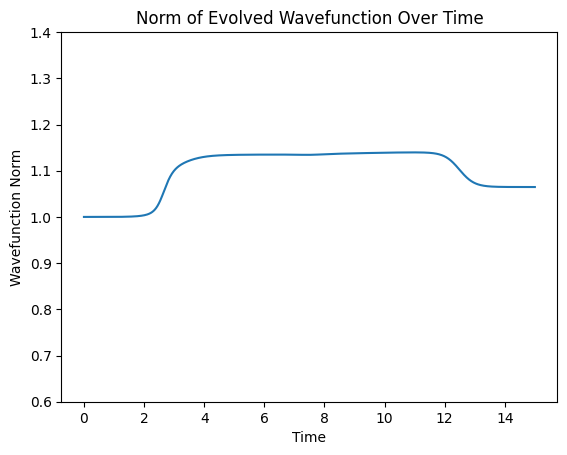

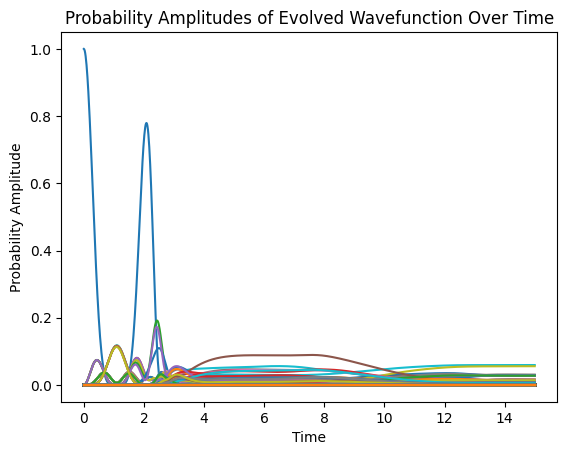

/home/Hishem/miniconda3/envs/myenv/lib/python3.14/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/Hishem/miniconda3/envs/myenv/lib/python3.14/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


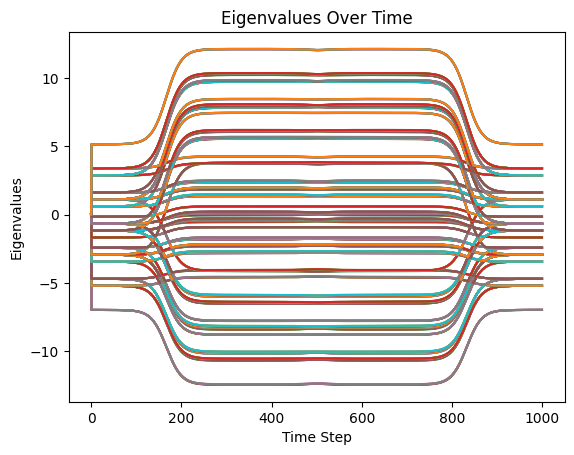

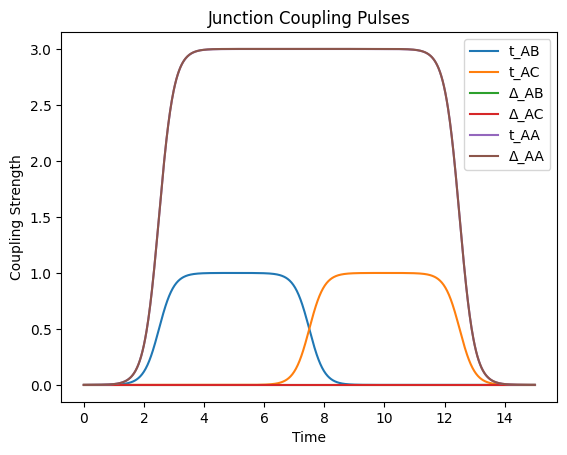

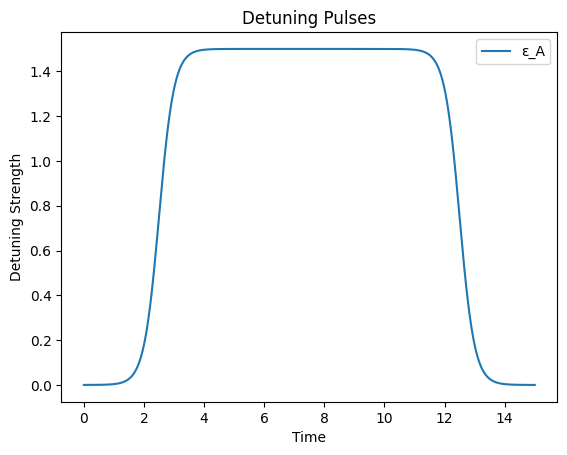

In [ ]:
print(np.max(eigvals))
plt.plot(time_array, norms)
plt.xlabel('Time')
plt.ylabel('Wavefunction Norm')
plt.title('Norm of Evolved Wavefunction Over Time')
plt.ylim(.6,1.4)
plt.show()

plt.plot(time_array, np.abs(Psi)**2)
plt.xlabel('Time')
plt.ylabel('Probability Amplitude')
plt.title('Probability Amplitudes of Evolved Wavefunction Over Time')
# plt.ylim(0, .2)
plt.show()  

plt.plot(eigvals)
plt.xlabel('Time Step')
plt.ylabel('Eigenvalues')
plt.title('Eigenvalues Over Time')
plt.show()


ab_pulse_tJ = [c[0][2] for c in couplings]
ab_pulse_dJ = [c[0][3] for c in couplings]
ac_pulse_tJ = [c[1][2] for c in couplings]
ac_pulse_dJ = [c[1][3] for c in couplings]
aa_pulse_tJ = [c[2][2] for c in couplings]
aa_pulse_dJ = [c[2][3] for c in couplings]
plt.plot(time_array, ab_pulse_tJ, label='t_AB')
plt.plot(time_array, ac_pulse_tJ, label='t_AC')
plt.plot(time_array, ab_pulse_dJ, label='Δ_AB')
plt.plot(time_array, ac_pulse_dJ, label='Δ_AC')
plt.plot(time_array, aa_pulse_tJ, label='t_AA')
plt.plot(time_array, aa_pulse_dJ, label='Δ_AA')

plt.xlabel('Time')
plt.ylabel('Coupling Strength')
plt.title('Junction Coupling Pulses')
plt.legend()
plt.show()

plt.plot(time_array, [d[0][2] for d in eps_detune], label='ε_A')
plt.xlabel('Time')
plt.ylabel('Detuning Strength')
plt.title('Detuning Pulses')
plt.legend()
plt.show()

In [ ]:
O = time_ev_operator
def orthonormalize(vs):
    """Orthonormalize columns of vs using QR decomposition."""
    q, _ = np.linalg.qr(vs)
    return q

# @njit
def berry_phase_kato(times, evecs):
    n = len(times)
    dt = times[1] - times[0]
    
    U = np.eye(512, dtype=np.complex128)

    for i in range(n - 1):
        # Pull out the two eigenvectors at step i and i+1
        v1 = evecs[i, :, 0]
        v2 = evecs[i, :, 1]
        w1 = evecs[i+1, :, 0]
        w2 = evecs[i+1, :, 1]

        # Build orthonormal subspace basis
        V = np.column_stack((v1, v2))
        W = np.column_stack((w1, w2))

        # [Optional] Align gauge by maximizing overlap
        # Replace with actual QR or SVD if needed

        P = V @ V.conj().T
        P_next = W @ W.conj().T

        dPdt = (P_next - P) / dt
        K = P @ dPdt - dPdt @ P

       # with objmode(tmp='complex128[:,:]'):
        tmp = expm(-dt * K)

        U = tmp @ U

    return U

bry = berry_phase_kato(time_array, eigvecs)
print(bry.shape)


(512, 512)


In [ ]:
def fidelity(ψ0, ψT):
    """
    Computes the fidelity between two states
    """
    return np.abs(np.vdot(ψ0, ψT))**2

E1 = eigvals[:, 1]
U = np.exp(-1j * Total_time * np.trapezoid(E1))*bry

Fidelity_Berry = fidelity(Psi[-1], U @ psi0)
print("Fidelity with Berry phase evolution:", Fidelity_Berry)

Fidelity with Berry phase evolution: 3.5175011909993956e-13


## Savings

In [ ]:
"""
Next:

1.
Check subsystem A, and how it evolves during braiding protocol.

2.
Compare berry phase for x energy levels at a time.
Compare with and without Coulomb interactions.

"""




# from scipy.linalg import svd

# def berry_unitary(eigvecs):
#     """
#     eigvecs: shape (Nt, dim, n_low)
#     returns: U_Berry (n_low x n_low)
#     """
#     Nt, dim, n_low = eigvecs.shape

#     U = np.eye(n_low, dtype=complex)

#     for i in range(Nt - 1):
#         Psi_t  = eigvecs[i]      # (dim, n_low)
#         Psi_tp = eigvecs[i + 1]  # (dim, n_low)

#         # overlap matrix
#         M = Psi_t.conj().T @ Psi_tp  # (n_low, n_low)

#         # polar decomposition → nearest unitary
#         U_m, _, Vh = svd(M)
#         M_unitary = U_m @ Vh

#         U = M_unitary @ U

#     return U

# print("Calculating Berry unitary...")
# U_Berry = berry_unitary(eigvecs)
# phase = np.linalg.det(U_Berry)**(1/lower_bound)
# U_Berry /= phase
# print("Berry unitary U_Berry:")
# # print(U_Berry)
# print(U_Berry.shape)
# print(np.sort(np.angle(np.linalg.eigvals(U_Berry))))


# H = big_H(n_sites, dupes, t, U, eps, Delta, couplings=couplings, eps_detune=eps_detune, operators=operators)

# ordered_couplings = {
#     "AB": {
#         "idx0": (0,2),
#         "idx1": (1,0),
#         "t_coup": None,
#         "Delta_coup": None
#     },
#     "eps_detune": None,
#     "BC": {
#         "idx0": (1,0),
#         "idx1": (2,0),
#         "t_coup": None,
#         "Delta_coup": None
#     },
# }


# def time_evolve(Total_time, n_steps, params, t_coup_max, Delta_coup_max, eps_detune_max, ordered_couplings, operators, lower_bound=10):

    
#     t_val, U_val, eps_val, Delta_val = params

#     couplings = []
#     eps_detune = {}
#     OC = ordered_couplings
#     for i in range(len(OC)): 
#         key = list(OC.keys())[i]
        
#         current = OC[key]
#         print(current)
#         if key == "eps_detune":
#             if current is not None:
#                 eps_detune = current
#             else: 
#                 eps_detune = {1: eps_detune_max}
#         else:
#             if current['t_coup'] is None:
#                 current['t_coup'] = t_coup_max
#             if current['Delta_coup'] is None:
#                 current['Delta_coup'] = Delta_coup_max
#             couplings.append([current['idx0'], current['idx1'], current['t_coup'], current['Delta_coup']])

#     print("Couplings for time evolution:", couplings)
#     print("Eps detune for time evolution:", eps_detune)


#     #Create Coupling pulse arrays:
#     time_array = np.linspace(0, Total_time, n_steps)
#     dt = time_array[1] - time_array[0]
#     ##Order of pulses AB peak at T=0 and T=Total_time, Eps Detune at T=Total_time/3, BC at T=2*Total_time/3
#     AB_t_peaks = [Total_time/3]#[0, Total_time]
#     BC_t_peaks = [2*Total_time/3]
#     eps_t_peaks = [0, Total_time]#[Total_time/3]

#     width = Total_time / 3
#     s = 20/width#Total_time * 6

#     All_Couplings = []
#     epsilons = []

#     # Precompute the pulses
#     for t in time_array:

#         eps_detune_val = simple_delta_pulse(t, eps_t_peaks[0], width, s, eps_detune_max , 0) + simple_delta_pulse(t, eps_t_peaks[1], width, s, eps_detune_max , 0)
#         epsilons.append(eps_detune_val)
        
#         current_couplings = []
#         for i,coup in enumerate(couplings):
#             # print(i, coup)
#             if i == 0:
#                 curr_t = simple_delta_pulse(t, AB_t_peaks[0], width, s, coup[2] , 0)# + simple_delta_pulse(t, AB_t_peaks[1], width, s, coup[2] , 0)
#                 curr_delta = simple_delta_pulse(t, AB_t_peaks[0], width, s, coup[3] , 0)# + simple_delta_pulse(t, AB_t_peaks[1], width, s, coup[3] , 0)
                
#                 current_coupling = [coup[0], coup[1], curr_t, curr_delta]
#                 current_couplings.append(current_coupling)
#             else:
#                 curr_t = simple_delta_pulse(t, BC_t_peaks[0], width, s, coup[2] , 0)
#                 curr_delta = simple_delta_pulse(t, BC_t_peaks[0], width, s, coup[3] , 0)
                
#                 current_coupling = [coup[0], coup[1], curr_t, curr_delta]
#                 current_couplings.append(current_coupling)

#         All_Couplings.append(current_couplings)
    

#     coupling_pulses = {
#         "AB_coupling": [All_Couplings[i][0] for i in range(len(All_Couplings))],
#         "BC_coupling": [All_Couplings[i][1] for i in range(len(All_Couplings))],
#         "eps_detune": epsilons
#     }

#     eigvals = np.zeros((n_steps, lower_bound))
#     eigvecs = np.zeros((n_steps, int(2**big_N), lower_bound), dtype=complex)
#     # Time Evolution
#     tJ = t_coup_max
#     dJ = Delta_coup_max
#     A = 0
#     B = 1
#     C = 2
#     gamma0_coupling = couplings = [
#     ((A,2), (B,0), tJ, dJ),
#     ((B,0), (C,0), tJ, dJ),
#     ((C,0), (A,2), tJ, dJ),
#     ]
#     #For each time step in ALL couplings, append gamma0coupling as well
#     for i in range(len(All_Couplings)):
#         for coup in gamma0_coupling:
#             All_Couplings[i].append(coup)
    
#     print(All_Couplings[0])

#     for i in tqdm(range(len(time_array))):
#         # H_t = big_H(n_sites, dupes, t_val, U_val, eps_val, Delta_val, couplings=All_Couplings[i], eps_detune={1: epsilons[i]}, operators=operators)
#         H_t = big_H(n_sites, dupes, t_val, U_val, eps_val, Delta_val, couplings=All_Couplings[i], eps_detune=0, operators=operators)
#         vals, vecs = np.linalg.eigh(H_t)
#         eigvals[i,:] = vals[:lower_bound]
#         eigvecs[i,:,:] = vecs[:,:lower_bound]

    
#     return eigvals, eigvecs, time_array, coupling_pulses
# T_total = 300
# n_steps = 1000
# t_coup_max = t_couple[0]/10
# Delta_coup_max = delta_couple[0]/10
# eps_detune_max = 1/10
# lower_bound = 8


# eigvals, eigvecs, time_array, coupling_pulses = time_evolve(T_total, n_steps, pars, t_coup_max, Delta_coup_max, eps_detune_max, ordered_couplings, operators, lower_bound=lower_bound)


def time_evolution(Total_time, n_steps, params, t_coup_max, Delta_coup_max, eps_detune_max, operators, lower_bound=10):
    print("Hei")
    t_val, U_val, eps_val, Delta_val = params

    tJ, dJ = t_coup_max, Delta_coup_max
    A = 0
    B = 1
    C = 2
    junction_mode = [
    ((A,2), (B,0), tJ, dJ),
    ((B,0), (C,0), tJ, dJ),
    ((C,0), (A,2), tJ, dJ),
    ]

    width = Total_time / 3
    s = 20/width#Total_time * 6

    time_array = np.linspace(0, Total_time, n_steps)
    dt = time_array[1] - time_array[0]

    eps_A_dict = {"site_idxs": [A], "node_idxs": [0], "vals": [0.0]}
    eps_B_dict = {"site_idxs": [B], "node_idxs": [2], "vals": [0.0]}
    eps_C_dict = {"site_idxs": [C], "node_idxs": [2], "vals": [0.0]}


    All_Couplings = []
    epsilons = []
    for t in time_array:
        eps_A = simple_delta_pulse(t, 0, width, s, eps_detune_max , 0) + simple_delta_pulse(t, Total_time, width, s, eps_detune_max , 0)
        eps_B = simple_delta_pulse(t, Total_time/3, width, s, eps_detune_max , 0)
        eps_C = simple_delta_pulse(t, 2*Total_time/3, width, s, eps_detune_max , 0)

        eps_A_dict["vals"] = [eps_A]
        eps_B_dict["vals"] = [eps_B]
        eps_C_dict["vals"] = [eps_C]
        epsilons.append([eps_A_dict, eps_B_dict, eps_C_dict])




        # AB_coup_t = simple_delta_pulse(t, 0, width, s, t_coup_max , 0) + simple_delta_pulse(t, Total_time, width, s, t_coup_max , 0)
        # AB_delta_t = simple_delta_pulse(t, 0, width, s, Delta_coup_max , 0) + simple_delta_pulse(t, Total_time, width, s, Delta_coup_max , 0)

        # BC_coup_t = simple_delta_pulse(t, Total_time/3, width, s, t_coup_max , 0)
        # BC_delta_t = simple_delta_pulse(t, Total_time/3, width, s, Delta_coup_max , 0)   

        # current_couplings = [
        #     ((A,2), (B,0), AB_coup_t, AB_delta_t),
        #     ((B,0), (C,0), BC_coup_t, BC_delta_t),
        # ]
        # junction mode
        # if t < Total_time / 3:
        #     current_couplings.append(junction_mode[0])
        # elif t < 2 * Total_time / 3:
        #     current_couplings.append(junction_mode[1])
        # else:
        #     current_couplings.append(junction_mode[2])

        # All_Couplings.append(current_couplings)
    
    pulse_info = {
        # "AB_coupling": [All_Couplings[i][0] for i in range(len(All_Couplings))],
        # "BC_coupling": [All_Couplings[i][1] for i in range(len(All_Couplings))],
        # "eps_detune": epsilons
        "epsA": [epsilons[i][0]["vals"] for i in range(len(epsilons))],
        "epsB": [epsilons[i][1]["vals"] for i in range(len(epsilons))],
        "epsC": [epsilons[i][2]["vals"] for i in range(len(epsilons))]
    }
    
    eigvals = np.zeros((n_steps, lower_bound))
    eigvecs = np.zeros((n_steps, int(2**big_N), lower_bound), dtype=complex)
    # Time Evolution
    for i in tqdm(range(len(time_array))):
        H_t = hamiltonian(n_sites, dupes, t_val, U_val, eps_val, Delta_val, couplings=junction_mode, eps_detune=epsilons[i], operators=operators)
        vals, vecs = np.linalg.eigh(H_t)
        eigvals[i,:] = vals[:lower_bound]
        eigvecs[i,:,:] = vecs[:,:lower_bound]

    return eigvals, eigvecs, time_array, pulse_info




